In [1]:
# Basic Data Handling
import numpy as np
import pandas as pd

# Visualization and Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import rasterio

# Machine Learning and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
import xgboost as xgb

# Deep Learning with Keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, Input, Add
from keras.layers import ZeroPadding2D, AveragePooling2D, GRU, MultiHeadAttention, LayerNormalization, DepthwiseConv2D, concatenate
from keras.initializers import glorot_uniform

# Miscellaneous Utilities
import graphviz

# Image Processing
from skimage.transform import resize


In [4]:
# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available.")
else:
    print("GPU is not available.")


GPU is available.


***

# Dataset for Modeling

In [27]:
pre_pseu_df = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/pre_pseu_iso_scaled.csv')

In [28]:
pre_pseu_df.shape

(484, 22)

# Implementation

In [3]:
pre_pseu_df = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/pre_pseu_iso_scaled.csv')

In [5]:
# Loading bioclimatic variables data
bioclim_data = []
# specific_columns = [1, 2, 3, 5, 6, 7, 8, 12, 14, 15, 18]

for i in range(1, 20):
# for i in specific_columns:
    file_name = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_" + str(i) + ".tif"
    with rasterio.open(file_name) as src:
        data = src.read(1).astype(np.float32)
        # Mask out nodata values
        data = np.ma.masked_equal(data, src.nodata)
        bioclim_data.append(data)

bioclim_data = np.stack(bioclim_data, axis=2)

In [6]:
bioclim_data

masked_array(
  data=[[[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         ...,
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.]],

        [[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         ...,
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  65535.,  65535.,  65535.]],

        [[-32768.,    255.,    127., ...,  65535.,  65535.,  65535.],
         [-32768.,    255.,    127., ...,  6

In [7]:
# Load data
df_presences = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/pres_bio_df.csv')
df_pseudoabsences = pd.read_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/saved_csv/rarified/carrots/unsuitable_iso_scaled.csv')

df_presences['presence']=1
df_pseudoabsences['presence']=0

In [8]:
df_presences.rename(columns={'SPECIES':'Species','LONGITUDE':'Longitude','LATITUDE':'Latitude'}, inplace=True)

In [9]:
df_presences

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-120.017765,41.172144,104,116,32,8215,314,-46,360,9,...,-1,199,24,5,38,71,17,17,71,1
1,-120.169580,40.107293,113,121,33,8008,318,-41,360,9,...,9,264,47,5,59,134,17,17,134,1
2,-120.044052,39.956218,95,122,34,7902,298,-59,357,-7,...,-7,286,53,6,61,150,19,19,150,1
3,-121.401984,39.138021,179,123,38,6535,362,46,316,93,...,93,707,141,1,84,401,5,5,401,1
4,-122.046262,38.815836,165,120,41,5716,331,41,290,88,...,88,501,112,1,94,319,5,5,319,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,-115.413850,32.761480,246,137,40,6988,429,92,337,154,...,154,67,10,0,58,28,0,22,28,1
238,-115.685708,32.696511,238,137,41,6646,418,89,328,151,...,151,94,15,0,58,43,2,26,43,1
239,-115.534941,32.716838,243,137,41,6856,425,91,334,153,...,153,76,11,0,59,33,1,24,33,1
240,-115.285428,32.740787,248,136,40,7073,431,93,339,155,...,155,63,10,0,61,26,0,21,26,1


In [10]:
df_pseudoabsences

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-117.236957,35.013687,197.0,129,36,7668.0,388.0,37.0,350.0,108.0,...,95.0,104.0,19.0,1.0,67.0,56.0,4.0,18.0,48.0,0
1,-115.951398,33.002929,233.0,136,41,6534.0,411.0,86.0,324.0,148.0,...,148.0,88.0,16.0,1.0,60.0,44.0,3.0,20.0,44.0,0
2,-121.349113,35.897220,112.0,97,47,3525.0,223.0,18.0,204.0,63.0,...,63.0,688.0,154.0,0.0,97.0,447.0,3.0,3.0,447.0,0
3,-116.047304,35.507290,208.0,127,34,8533.0,407.0,34.0,372.0,110.0,...,93.0,170.0,23.0,2.0,43.0,66.0,10.0,50.0,60.0,0
4,-115.879522,35.151983,204.0,129,35,8270.0,400.0,33.0,366.0,320.0,...,93.0,198.0,27.0,3.0,41.0,77.0,11.0,77.0,59.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,-116.600750,35.844081,248.0,123,32,8915.0,450.0,69.0,380.0,146.0,...,127.0,87.0,16.0,1.0,65.0,46.0,6.0,17.0,37.0,0
238,-114.847506,33.323160,241.0,132,38,7421.0,425.0,81.0,344.0,346.0,...,142.0,78.0,13.0,0.0,57.0,33.0,1.0,33.0,27.0,0
239,-123.436687,39.404299,123.0,86,40,4272.0,245.0,33.0,211.0,67.0,...,67.0,1343.0,256.0,2.0,81.0,737.0,15.0,23.0,737.0,0
240,-116.547566,35.611175,209.0,125,33,8492.0,407.0,37.0,370.0,110.0,...,95.0,108.0,20.0,1.0,66.0,58.0,5.0,22.0,49.0,0


In [11]:
# df_presences.drop(columns=['Species'])

In [12]:
pd.concat([df_presences,df_pseudoabsences])

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-120.017765,41.172144,104.0,116,32,8215.0,314.0,-46.0,360.0,9.0,...,-1.0,199.0,24.0,5.0,38.0,71.0,17.0,17.0,71.0,1
1,-120.169580,40.107293,113.0,121,33,8008.0,318.0,-41.0,360.0,9.0,...,9.0,264.0,47.0,5.0,59.0,134.0,17.0,17.0,134.0,1
2,-120.044052,39.956218,95.0,122,34,7902.0,298.0,-59.0,357.0,-7.0,...,-7.0,286.0,53.0,6.0,61.0,150.0,19.0,19.0,150.0,1
3,-121.401984,39.138021,179.0,123,38,6535.0,362.0,46.0,316.0,93.0,...,93.0,707.0,141.0,1.0,84.0,401.0,5.0,5.0,401.0,1
4,-122.046262,38.815836,165.0,120,41,5716.0,331.0,41.0,290.0,88.0,...,88.0,501.0,112.0,1.0,94.0,319.0,5.0,5.0,319.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,-116.600750,35.844081,248.0,123,32,8915.0,450.0,69.0,380.0,146.0,...,127.0,87.0,16.0,1.0,65.0,46.0,6.0,17.0,37.0,0
238,-114.847506,33.323160,241.0,132,38,7421.0,425.0,81.0,344.0,346.0,...,142.0,78.0,13.0,0.0,57.0,33.0,1.0,33.0,27.0,0
239,-123.436687,39.404299,123.0,86,40,4272.0,245.0,33.0,211.0,67.0,...,67.0,1343.0,256.0,2.0,81.0,737.0,15.0,23.0,737.0,0
240,-116.547566,35.611175,209.0,125,33,8492.0,407.0,37.0,370.0,110.0,...,95.0,108.0,20.0,1.0,66.0,58.0,5.0,22.0,49.0,0


## Extracting windowed data for CNN models 

### For Plaeoclim bioclimatic data

In [13]:
def extract_windowed_data(presence_points, bioclim_data, window_size=32):
    """
    Extracts windowed bioclimatic variable data around crop presence points.
    
    Parameters:
    -----------
    presence_points : pandas.DataFrame
        A pandas dataframe containing crop presence points with 'Longitude', 'Latitude', 
        and 'presence' columns.
    bioclim_data : numpy.ndarray
        A numpy array containing bioclimatic variable data.
    window_size : int, optional
        The size of the window around the crop presence point to extract. Default is 32.
        
    Returns:
    --------
    tuple
        A tuple containing two numpy arrays. The first array contains the extracted windowed
        bioclimatic variable data, and the second array contains the corresponding crop presence
        labels.
    """
    x = []
    y = []
    window_size=int(window_size/2)

    for _, row in presence_points.iterrows():
        # Converted latitude and longitude to pixel coordinates
        lon, lat = row['Longitude'], row['Latitude']
        x_coord, y_coord = src.index(lon, lat)
        #x_coord, y_coord = int(x_coord), int(y_coord)

        # Check if window is large enough
        if x_coord >= window_size and x_coord < src.width - window_size and \
           y_coord >= window_size and y_coord < src.height - window_size:
            # Extracted a window of size window_size X window_size around the crop presence point
            window = bioclim_data[y_coord-window_size:y_coord+window_size, x_coord-window_size:x_coord+window_size, :]

            # Append the window and patch area to lists
            x.append(window)
            y.append(row['presence'])

        else:
            print(f"Skipping crop presence point at ({lon}, {lat}) due to being too close to the edge.")

    # Convert to numpy arrays
    x = np.array(x)
    y = np.array(y)

    print(f"Number of crop presence points with large enough windows: {len(x)}")

    return x, y

In [14]:
# df_presences = df_presences[['Longitude', 'Latitude']]
# df_pseudoabsences = df_pseudoabsences[['Longitude', 'Latitude']]

In [15]:
x1,y1 = extract_windowed_data(df_presences, bioclim_data)

# x1,y1 = extract_windowed_data(presence_bio_df, bioclim_data)

Skipping crop presence point at (-114.504385685, 33.7213754525) due to being too close to the edge.
Skipping crop presence point at (-114.685746783, 33.6123476518) due to being too close to the edge.
Skipping crop presence point at (-114.533663682, 33.6120450267) due to being too close to the edge.
Skipping crop presence point at (-114.662444253, 33.507453432) due to being too close to the edge.
Skipping crop presence point at (-115.569369626, 33.325131833) due to being too close to the edge.
Skipping crop presence point at (-115.545457851, 33.2367652926) due to being too close to the edge.
Skipping crop presence point at (-115.413831521, 33.1801464963) due to being too close to the edge.
Skipping crop presence point at (-115.513509224, 33.1187605192) due to being too close to the edge.
Skipping crop presence point at (-115.362014984, 33.0968354349) due to being too close to the edge.
Skipping crop presence point at (-115.511868418, 33.0265213467) due to being too close to the edge.
Sk

In [16]:
x2,y2 = extract_windowed_data(df_pseudoabsences, bioclim_data)

# x2,y2 = extract_windowed_data(pseudoabsences_bio_df2, bioclim_data)

Skipping crop presence point at (-115.15416162542088, 33.967853805511915) due to being too close to the edge.
Skipping crop presence point at (-124.02181830459496, 41.20204042598064) due to being too close to the edge.
Skipping crop presence point at (-119.99419729128569, 41.71318026429232) due to being too close to the edge.
Skipping crop presence point at (-123.9600711358072, 40.61391542682368) due to being too close to the edge.
Skipping crop presence point at (-122.93353919165652, 41.92546495420186) due to being too close to the edge.
Skipping crop presence point at (-123.80380012492716, 41.46764981834326) due to being too close to the edge.
Skipping crop presence point at (-121.80388870142392, 41.97994092276758) due to being too close to the edge.
Skipping crop presence point at (-114.97677577215846, 34.94641429208163) due to being too close to the edge.
Skipping crop presence point at (-114.80624106961248, 34.86307801261889) due to being too close to the edge.
Skipping crop prese

### For averaged out future bioclimatic data from TDS catalog

In [42]:
from rasterio.windows import Window

def extract_windowed_data(presence_points, pseudo_absence_points, years, base_path, window_size):
    x = []
    y = []

    for points, presence_label in [(presence_points, 1), (pseudo_absence_points, 0)]:
        for _, row in points.iterrows():
            lon, lat = row['Longitude'], row['Latitude']
            sum_bioclim_data = None
            count_years = 0

            for year in years:
                valid_data = True
                for i in range(1, 20): 
                    file_name = f"{base_path}/bio{str(i).zfill(2)}_equiv_{year}_CA.tiff"

                    with rasterio.open(file_name) as src:
                        nodata = src.nodata  # Get the 'nodata' value from the raster file
                        x_coord, y_coord = src.index(lon, lat)

                        window = Window.from_slices((max(y_coord - window_size // 2, 0),
                                                     min(y_coord + window_size // 2, src.height)),
                                                    (max(x_coord - window_size // 2, 0),
                                                     min(x_coord + window_size // 2, src.width)))
                        data = src.read(1, window=window, masked=True)  # Read as a masked array

                        if sum_bioclim_data is None:
                            sum_bioclim_data = np.ma.zeros((window_size, window_size, 19), dtype=src.dtypes[0])

                        if data.shape == (window_size, window_size):
                            # Ensure data type matches that of sum_bioclim_data before adding
                            data_to_add = np.ma.masked_values(data, src.nodata).astype(sum_bioclim_data.dtype)
                            sum_bioclim_data[:, :, i-1] += data_to_add
                        else:
                            print(f"Data shape mismatch at point ({lon}, {lat}), year {year}, variable {i}")
                            valid_data = False
                            break

                if valid_data:
                    count_years += 1

            if count_years > 0:  # Ensure there's at least one valid year of data
                averaged_data = sum_bioclim_data.filled(-9999.0) / count_years  # Convert masked array to regular array, filling masked values
                x.append(averaged_data)
                y.append(presence_label)

    return np.array(x, dtype=object), np.array(y)


# # Example usage
# years = [2040, 2041, 2042, 2043, 2044, 2045, 2046]  # List the years you have data for
# base_path = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/2010-2100/2040_43" 
# window_size = 32  # desired window size
# presence_points = df_presences[['Longitude', 'Latitude']].copy() # presence points
# pseudo_absence_points = df_pseudoabsences[['Longitude', 'Latitude']].copy() # pseudo-absence points

# x, y = extract_windowed_data(presence_points, pseudo_absence_points, years, base_path, window_size)
# print("\n")
# print(f"Number of crop presence points with large enough windows {len(x)} & corresponding labels {len(y)}")

# `Model Iterations`

In [43]:
import time

start_time = time.time()

## Performance metric data frame 

In [44]:
import pandas as pd

# Initialized an empty DataFrame to store model metrics
model_metrics = pd.DataFrame(columns=['Model Name', 'Type','Epoch', 'Batch Size', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1 Score', 'Validation AUC', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score', 'Test AUC'])

# Function to append new model metrics
def append_model_metrics(metrics_df, name, type,epoch, batch_size,
                         accuracy_val, precision_val, recall_val, f1score_val, auc_val,
                         accuracy_test, precision_test, recall_test, f1score_test, auc_test):
    new_row = {
        'Model Name': name,
        'Type': type,
        'Epoch': epoch,
        'Batch Size': batch_size,
        'Validation Accuracy': accuracy_val,
        'Validation Precision': precision_val,
        'Validation Recall': recall_val,
        'Validation F1 Score': f1score_val,
        'Validation AUC': auc_val,
        'Test Accuracy': accuracy_test,
        'Test Precision': precision_test,
        'Test Recall': recall_test,
        'Test F1 Score': f1score_test,
        'Test AUC': auc_test
    }
    return pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)

## Data Preparation

In [45]:
pre_pseu_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-120.017765,41.172144,104.0,116,32,8215.0,314.0,-46.0,360.0,9.0,...,-1.0,199.0,24.0,5.0,38.0,71.0,17.0,17.0,71.0,1
1,-120.169580,40.107293,113.0,121,33,8008.0,318.0,-41.0,360.0,9.0,...,9.0,264.0,47.0,5.0,59.0,134.0,17.0,17.0,134.0,1
2,-120.044052,39.956218,95.0,122,34,7902.0,298.0,-59.0,357.0,-7.0,...,-7.0,286.0,53.0,6.0,61.0,150.0,19.0,19.0,150.0,1
3,-121.401984,39.138021,179.0,123,38,6535.0,362.0,46.0,316.0,93.0,...,93.0,707.0,141.0,1.0,84.0,401.0,5.0,5.0,401.0,1
4,-122.046262,38.815836,165.0,120,41,5716.0,331.0,41.0,290.0,88.0,...,88.0,501.0,112.0,1.0,94.0,319.0,5.0,5.0,319.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,-116.600750,35.844081,248.0,123,32,8915.0,450.0,69.0,380.0,146.0,...,127.0,87.0,16.0,1.0,65.0,46.0,6.0,17.0,37.0,0
480,-114.847506,33.323160,241.0,132,38,7421.0,425.0,81.0,344.0,346.0,...,142.0,78.0,13.0,0.0,57.0,33.0,1.0,33.0,27.0,0
481,-123.436687,39.404299,123.0,86,40,4272.0,245.0,33.0,211.0,67.0,...,67.0,1343.0,256.0,2.0,81.0,737.0,15.0,23.0,737.0,0
482,-116.547566,35.611175,209.0,125,33,8492.0,407.0,37.0,370.0,110.0,...,95.0,108.0,20.0,1.0,66.0,58.0,5.0,22.0,49.0,0


In [46]:
pre_pseu_df.iloc[:, 2:21]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,104.0,116,32,8215.0,314.0,-46.0,360.0,9.0,228.0,228.0,-1.0,199.0,24.0,5.0,38.0,71.0,17.0,17.0,71.0
1,113.0,121,33,8008.0,318.0,-41.0,360.0,9.0,232.0,232.0,9.0,264.0,47.0,5.0,59.0,134.0,17.0,17.0,134.0
2,95.0,122,34,7902.0,298.0,-59.0,357.0,-7.0,212.0,212.0,-7.0,286.0,53.0,6.0,61.0,150.0,19.0,19.0,150.0
3,179.0,123,38,6535.0,362.0,46.0,316.0,93.0,272.0,272.0,93.0,707.0,141.0,1.0,84.0,401.0,5.0,5.0,401.0
4,165.0,120,41,5716.0,331.0,41.0,290.0,88.0,244.0,244.0,88.0,501.0,112.0,1.0,94.0,319.0,5.0,5.0,319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,248.0,123,32,8915.0,450.0,69.0,380.0,146.0,325.0,372.0,127.0,87.0,16.0,1.0,65.0,46.0,6.0,17.0,37.0
480,241.0,132,38,7421.0,425.0,81.0,344.0,346.0,301.0,346.0,142.0,78.0,13.0,0.0,57.0,33.0,1.0,33.0,27.0
481,123.0,86,40,4272.0,245.0,33.0,211.0,67.0,178.0,185.0,67.0,1343.0,256.0,2.0,81.0,737.0,15.0,23.0,737.0
482,209.0,125,33,8492.0,407.0,37.0,370.0,110.0,282.0,328.0,95.0,108.0,20.0,1.0,66.0,58.0,5.0,22.0,49.0


In [4]:
pre_pseu_df['presence'].value_counts()

presence
1    242
0    242
Name: count, dtype: int64

# `Traditional Models`

In [48]:
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask

# California boundary shapefile
california_boundary = gpd.read_file('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/California_County_Boundaries.geojson')

# List of bioclimatic variable file paths
bioclim_files = [
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_1.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_2.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_3.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_4.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_5.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_6.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_7.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_8.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_9.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_10.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_11.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_12.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_13.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_14.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_15.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_16.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_17.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_18.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_19.tif',

]

# all rasters have the same extent and resolution
with rasterio.open(bioclim_files[0]) as src:
    meta = src.meta
    
    # California boundary is in the same CRS as the raster
    california_boundary = california_boundary.to_crs(meta['crs'])
    
    # mask for the area outside the California boundary
    mask = geometry_mask([geometry for geometry in california_boundary.geometry],
                         transform=src.transform,
                         invert=True,  # We want 'True' inside the boundary
                         out_shape=(meta['height'], meta['width']))

    # an array to hold the bioclimatic data
    grid_bioclim = np.zeros((np.sum(mask), len(bioclim_files))) 

idx = 0

# Extracting the values for each bioclimatic variable inside the mask
for i, file in enumerate(bioclim_files):
    with rasterio.open(file) as src:
        band = src.read(1)  # read the only band of the raster
        masked_band = band[mask]
        grid_bioclim[:, i] = masked_band


## Stacked Classifier

### Dropping monotonic features

In [49]:
# pre_pseu_df_drp = pre_pseu_df.drop(columns=['Longitude','Latitude','bio_4', 'bio_9', 'bio_10', 'bio_11', 'bio_13', 'bio_16', 'bio_19', 'bio_17','presence'])

In [50]:
# Data Preparation
X = pre_pseu_df.iloc[:, 2:21].values  # feature columns
# X = pre_pseu_df_drp.values
y = pre_pseu_df['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fit the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# base learners
base_learners = [
    ('dt', DecisionTreeClassifier(max_depth=3)),
    ('svm', SVC(probability=True))
]

# meta-learner
meta_learner = LogisticRegression()

# stacking model
model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# train the model
model.fit(X_train, y_train)


StackingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=3)),
                               ('svm', SVC(probability=True))],
                   final_estimator=LogisticRegression())

In [51]:

# Predict on validation set
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)[:, 1]

# Predict on test set
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

# Evaluation on Validation Set
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Accuracy       :", accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)


Validation Accuracy : 0.9315068493150684
Validation Precision: 0.9310344827586207
Validation Recall   : 0.9
Validation F1 Score : 0.9152542372881356
Validation AUC      : 0.9627906976744186
Test Accuracy       : 0.958904109589041
Test Precision      : 0.9761904761904762
Test Recall         : 0.9534883720930233
Test F1 Score       : 0.9647058823529412
Test AUC            : 0.9658914728682171


In [52]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(338, 19) (73, 19) (73, 19)
(338,) (73,) (73,)


In [53]:
unique_values = set(y_test)

value_counts = {}
for value in unique_values:
    if isinstance(y_test, list):
        value_counts[value] = y_test.count(value)
    elif isinstance(y_test, np.ndarray):
        value_counts[value] = np.count_nonzero(y_test == value)

for value, count in value_counts.items():
    print(f"{value}: {count}")

0: 30
1: 43


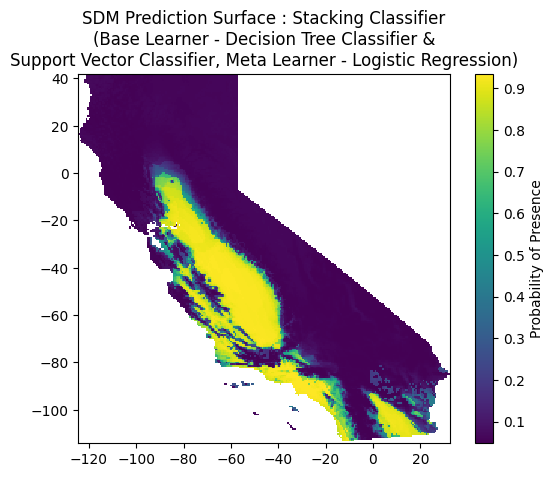

In [54]:
# Normalize the bioclimatic variables for the grid using the trained scaler
grid_bioclim_scaled = scaler.transform(grid_bioclim)

# predictions
predictions = model.predict_proba(grid_bioclim_scaled)[:, 1]  # probability of presence

# empty array for the entire grid
full_grid_predictions = np.empty(mask.shape)
full_grid_predictions.fill(np.nan)  # Fill with NaNs

# Placing predictions inside California
full_grid_predictions[mask] = predictions

prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot (prediction surface + mask)
plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface : Stacking Classifier\n'
          '(Base Learner - Decision Tree Classifier &\n'
          'Support Vector Classifier, Meta Learner - Logistic Regression)')
plt.show()


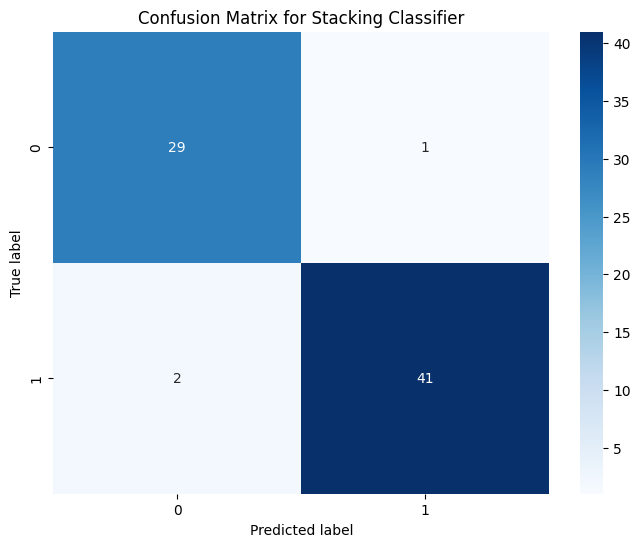

In [55]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Stacking Classifier')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Stacked Classifier',
    type='Traditional',
    epoch=str("-"),
    batch_size=str("-"),
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Gradient Boosting Machines (GBM)

In [57]:
# Data Preparation
X = pre_pseu_df.iloc[:, 2:21].values  # feature columns
# X = pre_pseu_df_drp.values
y = pre_pseu_df['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fit the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialized the Gradient Boosting
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

# Trained the model
model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42)

In [58]:

# Predict on validation set
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)[:, 1]

# Predict on test set
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

# Evaluation on Validation Set
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Accuracy       :", accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)


Validation Accuracy : 0.9452054794520548
Validation Precision: 0.9333333333333333
Validation Recall   : 0.9333333333333333
Validation F1 Score : 0.9333333333333333
Validation AUC      : 0.989922480620155
Test Accuracy       : 0.958904109589041
Test Precision      : 0.9761904761904762
Test Recall         : 0.9534883720930233
Test F1 Score       : 0.9647058823529412
Test AUC            : 0.9945736434108527


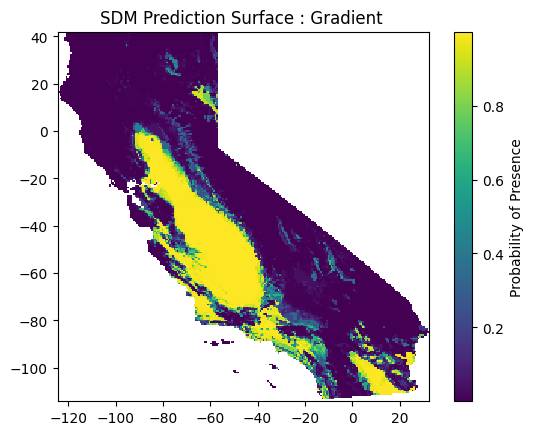

In [60]:
# Normalize the bioclimatic variables for the grid using the trained scaler
grid_bioclim_scaled = scaler.transform(grid_bioclim)

# predictions
predictions = model.predict_proba(grid_bioclim_scaled)[:, 1]  # probability of presence

# empty array for the entire grid
full_grid_predictions = np.empty(mask.shape)
full_grid_predictions.fill(np.nan)  # Fill with NaNs

# Placing predictions inside California
full_grid_predictions[mask] = predictions

prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot (prediction surface + mask)
prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot the prediction surface with the mask applied
plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface : Gradient ')
plt.show()


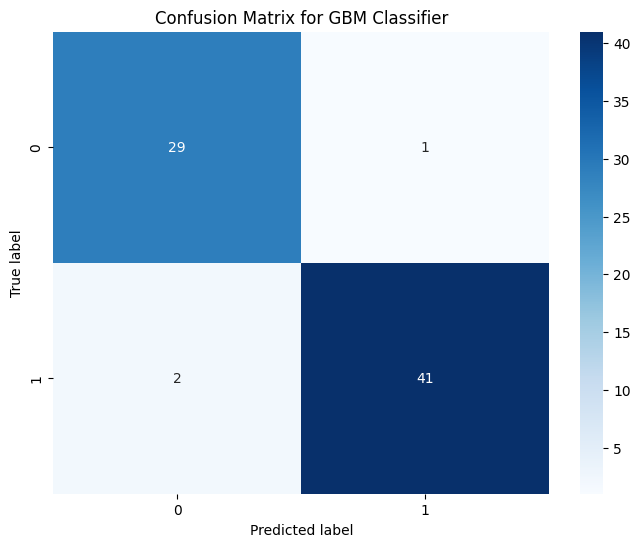

In [61]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for GBM Classifier')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [62]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Gradient Boosting',
    type='Traditional',
    epoch=str("-"),
    batch_size=str("-"),
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## XGBoost Classifier

In [63]:
# Data Preparation
X = pre_pseu_df.iloc[:, 2:21].values  # feature columns
# X = pre_pseu_df_drp.values
y = pre_pseu_df['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fit the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize the  XGBoost
xgboost_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False)

# Train the model
xgboost_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [64]:

# Predict on validation set
y_pred_val = xgboost_model.predict(X_val)
y_pred_proba_val = xgboost_model.predict_proba(X_val)[:, 1]

# Predict on test set
y_pred_test = xgboost_model.predict(X_test)
y_pred_proba_test = xgboost_model.predict_proba(X_test)[:, 1]

# Evaluation on Validation Set
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Accuracy       :", accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)


Validation Accuracy : 0.9452054794520548
Validation Precision: 0.9333333333333333
Validation Recall   : 0.9333333333333333
Validation F1 Score : 0.9333333333333333
Validation AUC      : 0.9837209302325581
Test Accuracy       : 0.9452054794520548
Test Precision      : 0.975609756097561
Test Recall         : 0.9302325581395349
Test F1 Score       : 0.9523809523809524
Test AUC            : 0.9961240310077519


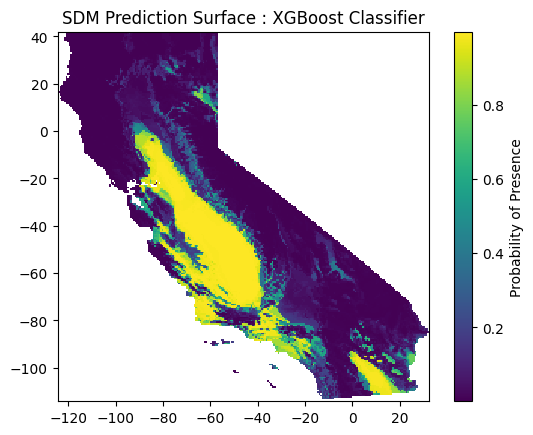

In [65]:
# Normalize the bioclimatic variables for the grid using the trained scaler
grid_bioclim_scaled = scaler.transform(grid_bioclim)

# predictions
predictions = xgboost_model.predict_proba(grid_bioclim_scaled)[:, 1]  # probability of presence

# empty array for the entire grid
full_grid_predictions = np.empty(mask.shape)
full_grid_predictions.fill(np.nan)  # Fill with NaNs

# Placing predictions inside California
full_grid_predictions[mask] = predictions

prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot (prediction surface + mask)
prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot the prediction surface with the mask applied
plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface : XGBoost Classifier')
plt.show()


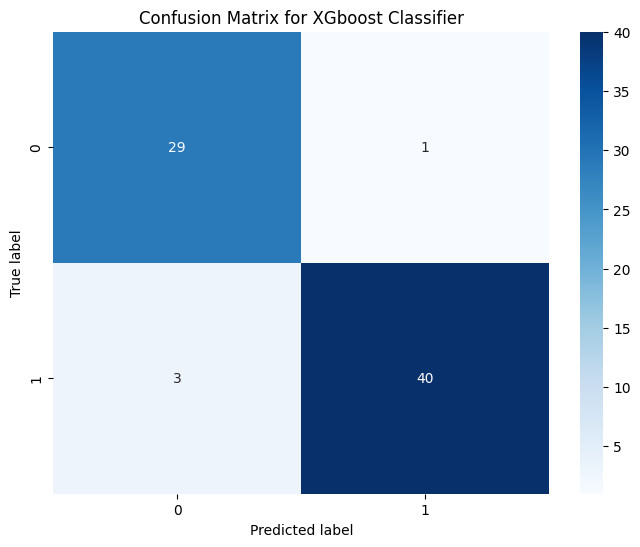

In [66]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGboost Classifier')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [67]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='XGBoost',
    type='Traditional',
    epoch=str("-"),
    batch_size=str("-"),
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Bagging RandomForest

In [68]:
# Data Preparation
X = pre_pseu_df.iloc[:, 2:21].values  # feature columns
# X = pre_pseu_df_drp.values
y = pre_pseu_df['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fit the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize the Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False)

# Train the model
random_forest.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, random_state=42)

In [69]:

# Predict on validation set
y_pred_val = random_forest.predict(X_val)
y_pred_proba_val = random_forest.predict_proba(X_val)[:, 1]

# Predict on test set
y_pred_test = random_forest.predict(X_test)
y_pred_proba_test = random_forest.predict_proba(X_test)[:, 1]

# Evaluation on Validation Set
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Accuracy       :", accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)


Validation Accuracy : 0.958904109589041
Validation Precision: 0.9655172413793104
Validation Recall   : 0.9333333333333333
Validation F1 Score : 0.9491525423728815
Validation AUC      : 0.9910852713178295
Test Accuracy       : 0.958904109589041
Test Precision      : 0.9761904761904762
Test Recall         : 0.9534883720930233
Test F1 Score       : 0.9647058823529412
Test AUC            : 0.9949612403100775


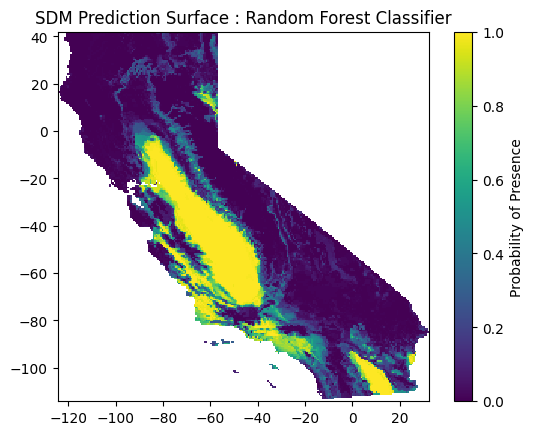

In [70]:
# Normalize the bioclimatic variables for the grid using the trained scaler
grid_bioclim_scaled = scaler.transform(grid_bioclim)

# predictions
predictions = random_forest.predict_proba(grid_bioclim_scaled)[:, 1]  # probability of presence

# empty array for the entire grid
full_grid_predictions = np.empty(mask.shape)
full_grid_predictions.fill(np.nan)  # Fill with NaNs

# Placing predictions inside California
full_grid_predictions[mask] = predictions

prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot (prediction surface + mask)
prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot the prediction surface with the mask applied
plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface : Random Forest Classifier')
plt.show()


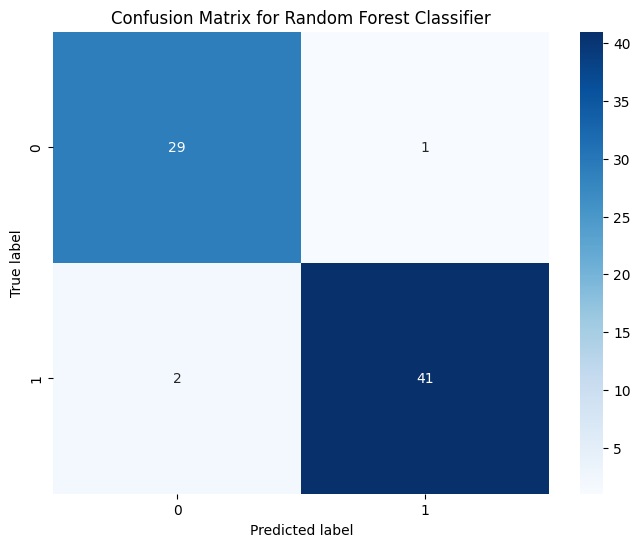

In [71]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [72]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Random Forest',
    type='Traditional',
    epoch=str("-"),
    batch_size=str("-"),
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

In [73]:
# # Extract a single tree
# single_tree = random_forest.estimators_[0]

# # Export as dot file
# export_graphviz(single_tree, out_file='tree.dot', 
#                 feature_names = pre_pseu_df.columns[2:21],
#                 class_names = ['Absence', 'Presence'],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Use dot file to create a graph
# with open('tree.dot') as f:
#     dot_graph = f.read()

# # Display the graph
# graphviz.Source(dot_graph)


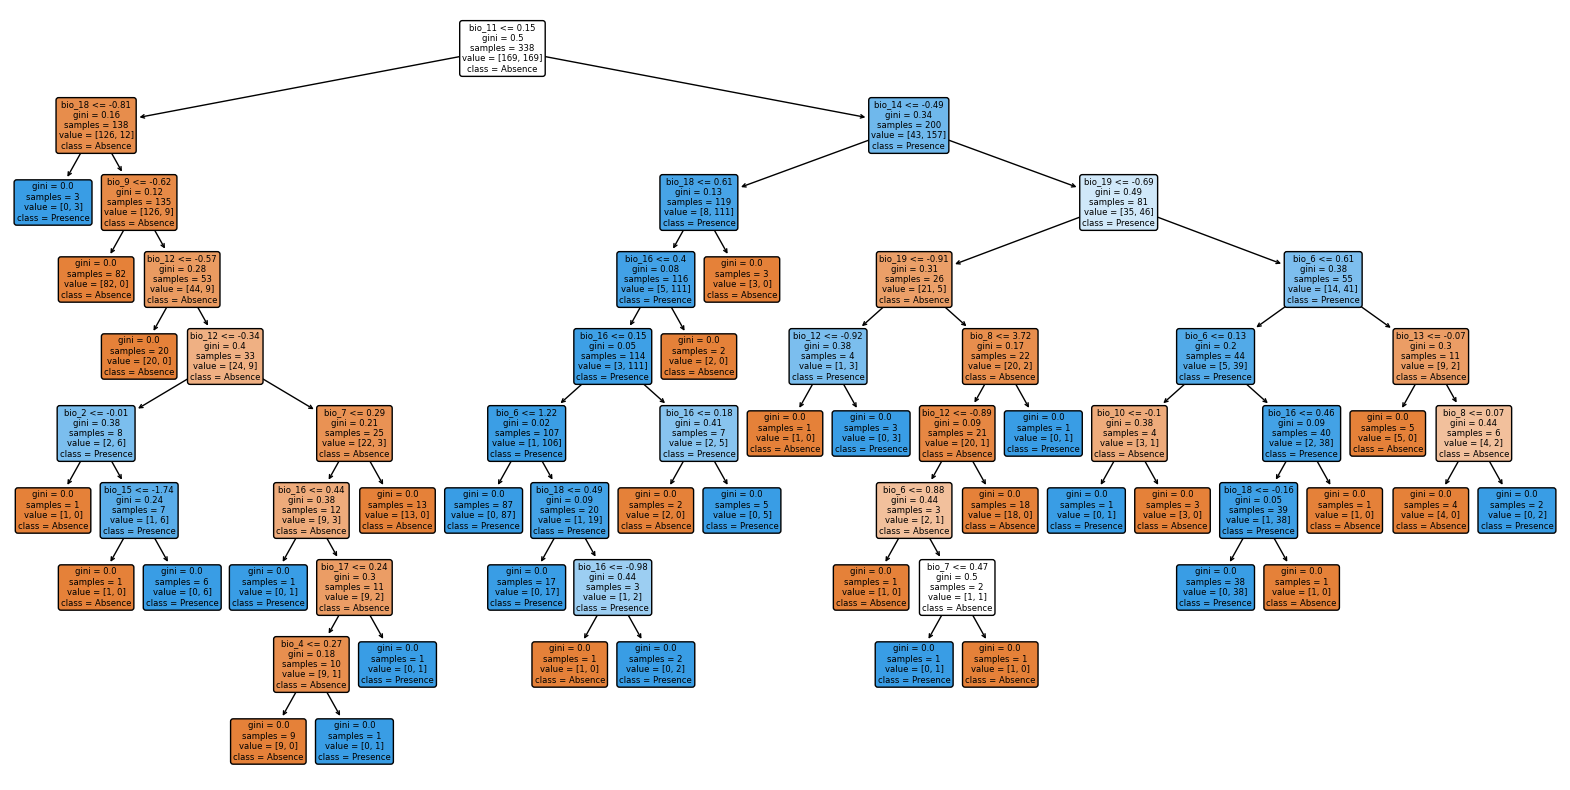

In [74]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

single_tree = random_forest.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(single_tree, 
          feature_names=pre_pseu_df.columns[2:21], 
          class_names=['Absence', 'Presence'], 
          filled=True, rounded=True, 
          precision=2)
plt.show()


In [75]:
model_metrics

,Model Name,Type,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,Stacked Classifier,Traditional,-,-,0.931507,0.931034,0.900000,0.915254,0.962791,0.958904,0.97619,0.953488,0.964706,0.965891
1,Gradient Boosting,Traditional,-,-,0.945205,0.933333,0.933333,0.933333,0.989922,0.958904,0.97619,0.953488,0.964706,0.994574
2,XGBoost,Traditional,-,-,0.945205,0.933333,0.933333,0.933333,0.983721,0.945205,0.97561,0.930233,0.952381,0.996124
3,Random Forest,Traditional,-,-,0.958904,0.965517,0.933333,0.949153,0.991085,0.958904,0.97619,0.953488,0.964706,0.994961


# `Deep Learning Networks`

In [76]:
# Load the California boundary shapefile
california_boundary = gpd.read_file('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/California_County_Boundaries.geojson')

# List of bioclimatic variable file paths
bioclim_files = [
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_1.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_2.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_3.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_4.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_5.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_6.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_7.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_8.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_9.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_10.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_11.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_12.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_13.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_14.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_15.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_16.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_17.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_18.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_19.tif',

]

# all rasters have the same extent and resolution
with rasterio.open(bioclim_files[0]) as src:
    meta = src.meta
    
    # California boundary is in the same CRS as the raster
    california_boundary = california_boundary.to_crs(meta['crs'])
    
    # mask for the area outside the California boundary
    mask = geometry_mask([geometry for geometry in california_boundary.geometry],
                         transform=src.transform,
                         invert=True,  # We want 'True' inside the boundary
                         out_shape=(meta['height'], meta['width']))

    # an array to hold the bioclimatic data
    grid_bioclim = np.zeros((np.sum(mask), len(bioclim_files)))  


idx = 0

# Extracting the values for each bioclimatic variable inside the mask
for i, file in enumerate(bioclim_files):
    with rasterio.open(file) as src:
        band = src.read(1)  # read the only band of the raster
        masked_band = band[mask]
        grid_bioclim[:, i] = masked_band

## Keras Sequential

In [77]:
pre_pseu_df.iloc[:, 2:21]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,104.0,116,32,8215.0,314.0,-46.0,360.0,9.0,228.0,228.0,-1.0,199.0,24.0,5.0,38.0,71.0,17.0,17.0,71.0
1,113.0,121,33,8008.0,318.0,-41.0,360.0,9.0,232.0,232.0,9.0,264.0,47.0,5.0,59.0,134.0,17.0,17.0,134.0
2,95.0,122,34,7902.0,298.0,-59.0,357.0,-7.0,212.0,212.0,-7.0,286.0,53.0,6.0,61.0,150.0,19.0,19.0,150.0
3,179.0,123,38,6535.0,362.0,46.0,316.0,93.0,272.0,272.0,93.0,707.0,141.0,1.0,84.0,401.0,5.0,5.0,401.0
4,165.0,120,41,5716.0,331.0,41.0,290.0,88.0,244.0,244.0,88.0,501.0,112.0,1.0,94.0,319.0,5.0,5.0,319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,248.0,123,32,8915.0,450.0,69.0,380.0,146.0,325.0,372.0,127.0,87.0,16.0,1.0,65.0,46.0,6.0,17.0,37.0
480,241.0,132,38,7421.0,425.0,81.0,344.0,346.0,301.0,346.0,142.0,78.0,13.0,0.0,57.0,33.0,1.0,33.0,27.0
481,123.0,86,40,4272.0,245.0,33.0,211.0,67.0,178.0,185.0,67.0,1343.0,256.0,2.0,81.0,737.0,15.0,23.0,737.0
482,209.0,125,33,8492.0,407.0,37.0,370.0,110.0,282.0,328.0,95.0,108.0,20.0,1.0,66.0,58.0,5.0,22.0,49.0


In [78]:
# Data Preparation
X = pre_pseu_df.iloc[:, 2:21].values  # feature columns
# X = pre_pseu_df_drp.values
y = pre_pseu_df['presence'].values  # target column

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Splitting into 70% training and 30% temporary
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temporary into 50% validation and 50% test

# Data normalization - fit the scaler only on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [79]:
print(X_train.shape, X_val.shape, X_test.shape)
print('\n')
print(y_train.shape, y_val.shape, y_test.shape)

(338, 19) (73, 19) (73, 19)


(338,) (73,) (73,)


In [80]:
unique_values = set(y_test)

value_counts = {}
for value in unique_values:
    if isinstance(y_test, list):
        value_counts[value] = y_test.count(value)
    elif isinstance(y_test, np.ndarray):
        value_counts[value] = np.count_nonzero(y_test == value)

for value, count in value_counts.items():
    print(f"{value}: {count}")

0: 30
1: 43


In [81]:
# Build the model
model_ks = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_ks.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2024-03-21 18:16:33.604281: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-21 18:16:33.604408: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-21 18:16:33.604642: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-21 18:16:33.605092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-21 18:16:33.606008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [82]:
# Train the model using training and validation sets
history = model_ks.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20


2024-03-21 18:16:44.932333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 143ms/step - loss: 0.5942 - accuracy: 0.7160 - val_loss: 0.4241 - val_accuracy: 0.8219
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 0.4796 - accuracy: 0.8077 - val_loss: 0.4063 - val_accuracy: 0.8082
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 0.4129 - accuracy: 0.8195 - val_loss: 0.3683 - val_accuracy: 0.8356
Epoch 4/20
11/11 [==============================] - 0s 6ms/step - loss: 0.3557 - accuracy: 0.8373 - val_loss: 0.3555 - val_accuracy: 0.8493
Epoch 5/20
11/11 [==============================] - 0s 6ms/step - loss: 0.4017 - accuracy: 0.8254 - val_loss: 0.3400 - val_accuracy: 0.8630
Epoch 6/20
11/11 [==============================] - 0s 7ms/step - loss: 0.3495 - accuracy: 0.8550 - val_loss: 0.3329 - val_accuracy: 0.8630
Epoch 7/20
11/11 [==============================] - 0s 9ms/step - loss: 0.3340 - accuracy: 0.8462 - val_loss: 0.3242 - val_accuracy: 0.8630
Epoch 8/20
11/11 [==========

In [83]:

# Evaluate the model on the test data
test_loss, test_acc = model_ks.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on validation set
y_pred_proba_val = model_ks.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_ks.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test=test_acc

3/3 [==============================] - 0s 4ms/step - loss: 0.1971 - accuracy: 0.9315
Test accuracy: 0.931506872177124


3/3 [==============================] - 0s 2ms/step
Validation Accuracy: 0.9041095890410958
Validation Precision: 0.8484848484848485
Validation Recall   : 0.9333333333333333
Validation F1 Score : 0.888888888888889
Validation AUC      : 0.9542635658914729
Test Precision      : 0.9318181818181818
Test Recall         : 0.9534883720930233
Test F1 Score       : 0.942528735632184
Test AUC            : 0.9759689922480621


 46/749 [>.............................] - ETA: 0s

749/749 [==============================] - 1s 1ms/step


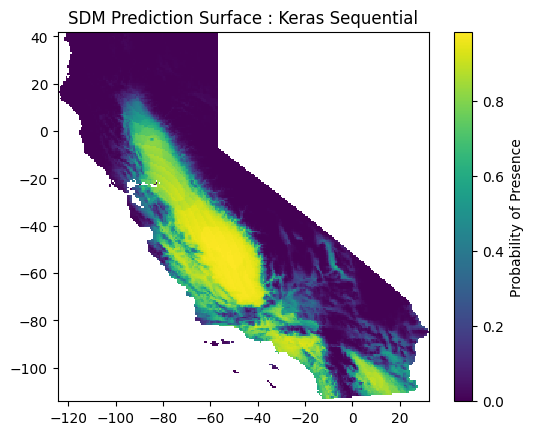

In [86]:
# Normalize the bioclimatic variables for the grid using the trained scaler
grid_bioclim_scaled = scaler.transform(grid_bioclim)

# predictions
predictions = model_ks.predict(grid_bioclim_scaled).flatten()  # flatten the predictions

# empty array for the entire grid
full_grid_predictions = np.empty(mask.shape)
full_grid_predictions.fill(np.nan)  # Fill with NaNs

# Place predictions inside California
full_grid_predictions[mask] = predictions

# Plot (prediction surface + mask)
prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot the prediction surface
plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface : Keras Sequential')
plt.show()


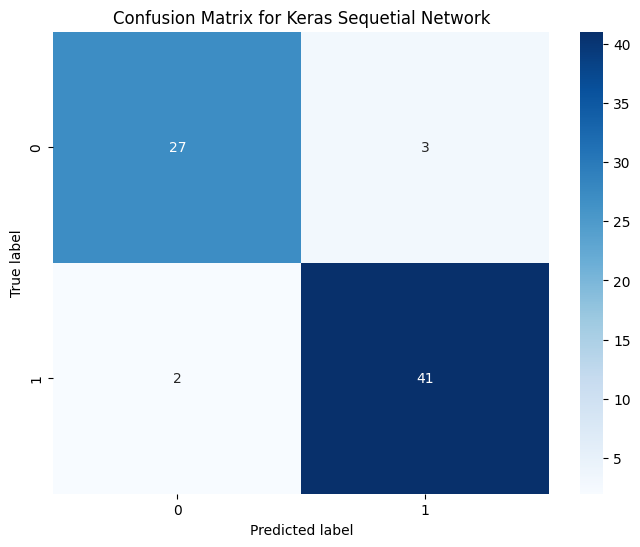

In [87]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Keras Sequetial Network')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [88]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Neural Network',
    type='Deep Learning',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Multi Layer Perceptron

In [89]:
model_enhanced_mlp = Sequential()
model_enhanced_mlp.add(Dense(128, input_shape=(X_train.shape[1],)))
model_enhanced_mlp.add(BatchNormalization())
model_enhanced_mlp.add(Activation('relu'))
model_enhanced_mlp.add(Dropout(0.5))
model_enhanced_mlp.add(Dense(64))
model_enhanced_mlp.add(BatchNormalization())
model_enhanced_mlp.add(Activation('relu'))
model_enhanced_mlp.add(Dropout(0.5))
model_enhanced_mlp.add(Dense(1, activation='sigmoid'))

model_enhanced_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [90]:
# Train the model using training and validation sets
history = model_enhanced_mlp.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20


11/11 [==============================] - 1s 59ms/step - loss: 0.7435 - accuracy: 0.5976 - val_loss: 0.5298 - val_accuracy: 0.7671
Epoch 2/20
11/11 [==============================] - 0s 9ms/step - loss: 0.4896 - accuracy: 0.7781 - val_loss: 0.4455 - val_accuracy: 0.7945
Epoch 3/20
11/11 [==============================] - 0s 9ms/step - loss: 0.3865 - accuracy: 0.8343 - val_loss: 0.3949 - val_accuracy: 0.8630
Epoch 4/20
11/11 [==============================] - 0s 9ms/step - loss: 0.3234 - accuracy: 0.8609 - val_loss: 0.3653 - val_accuracy: 0.9041
Epoch 5/20
11/11 [==============================] - 0s 8ms/step - loss: 0.3797 - accuracy: 0.8373 - val_loss: 0.3509 - val_accuracy: 0.9178
Epoch 6/20
11/11 [==============================] - 0s 8ms/step - loss: 0.3173 - accuracy: 0.8846 - val_loss: 0.3360 - val_accuracy: 0.9452
Epoch 7/20
11/11 [==============================] - 0s 8ms/step - loss: 0.2849 - accuracy: 0.8846 - val_loss: 0.3264 - val_accuracy: 0.9315
Epoch 8/20
11/11 [============

In [91]:

# Evaluate the model on the test data
test_loss, test_acc = model_enhanced_mlp.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on validation set
y_pred_proba_val = model_enhanced_mlp.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_enhanced_mlp.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test=test_acc

3/3 [==============================] - 0s 4ms/step - loss: 0.2220 - accuracy: 0.9452
Test accuracy: 0.9452054500579834


3/3 [==============================] - 0s 2ms/step
Validation Accuracy: 0.9178082191780822
Validation Precision: 0.8529411764705882
Validation Recall   : 0.9666666666666667
Validation F1 Score : 0.90625
Validation AUC      : 0.9720930232558139
Test Precision      : 0.9148936170212766
Test Recall         : 1.0
Test F1 Score       : 0.9555555555555556
Test AUC            : 0.975968992248062


 34/749 [>.............................] - ETA: 1s 

749/749 [==============================] - 1s 1ms/step


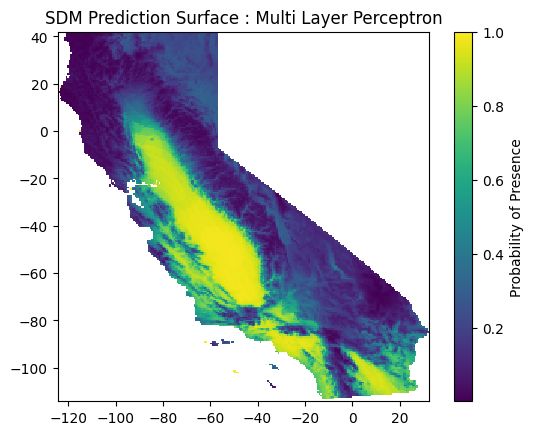

In [92]:
# Normalize the bioclimatic variables for the grid using the trained scaler
grid_bioclim_scaled = scaler.transform(grid_bioclim)

# predictions
predictions = model_enhanced_mlp.predict(grid_bioclim_scaled).flatten()  # flatten the predictions

# empty array for the entire grid
full_grid_predictions = np.empty(mask.shape)
full_grid_predictions.fill(np.nan)  # Fill with NaNs

# Place predictions inside California
full_grid_predictions[mask] = predictions

# Plot (prediction surface + mask)
prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot the prediction surface
plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface : Multi Layer Perceptron')
plt.show()

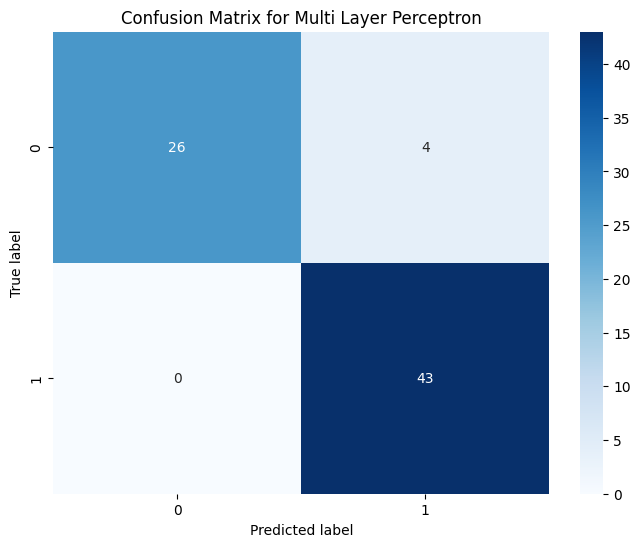

In [93]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Multi Layer Perceptron')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [94]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Multi Layer Perceptron',
    type='Deep Learning',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Autoencoder

In [95]:
# Define encoder
input_data = Input(shape=(X_train.shape[1],))
encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(32, activation='relu')(encoded)

# Define decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

# Autoencoder
autoencoder = Model(input_data, decoded)

# Encoder - for dimensionality reduction
encoder = Model(input_data, encoded)

# Compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# using the encoded layer's output as features for classification
encoded_input = Input(shape=(X_train.shape[1],))
classifier_layer = Dense(1, activation='sigmoid')(encoded_input)
classifier = Model(encoded_input, classifier_layer)

# compile and train the classifier model normally using the encoded inputs
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [96]:
# Train the model using training and validation sets
history = classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20


11/11 [==============================] - 1s 58ms/step - loss: 0.7862 - accuracy: 0.5118 - val_loss: 0.7470 - val_accuracy: 0.5616
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 0.7431 - accuracy: 0.5414 - val_loss: 0.7049 - val_accuracy: 0.5890
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 0.7023 - accuracy: 0.5799 - val_loss: 0.6688 - val_accuracy: 0.6301
Epoch 4/20
11/11 [==============================] - 0s 6ms/step - loss: 0.6664 - accuracy: 0.6272 - val_loss: 0.6369 - val_accuracy: 0.6849
Epoch 5/20
11/11 [==============================] - 0s 6ms/step - loss: 0.6333 - accuracy: 0.6775 - val_loss: 0.6094 - val_accuracy: 0.6986
Epoch 6/20
11/11 [==============================] - 0s 6ms/step - loss: 0.6054 - accuracy: 0.6923 - val_loss: 0.5847 - val_accuracy: 0.7123
Epoch 7/20
11/11 [==============================] - 0s 8ms/step - loss: 0.5808 - accuracy: 0.7396 - val_loss: 0.5628 - val_accuracy: 0.7397
Epoch 8/20
11/11 [===========

In [97]:

# Evaluate the model on the test data
test_loss, test_acc = classifier.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on validation set
y_pred_proba_val = classifier.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = classifier.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test=test_acc

3/3 [==============================] - 0s 4ms/step - loss: 0.4189 - accuracy: 0.8219
Test accuracy: 0.8219178318977356
3/3 [==============================] - 0s 3ms/step


3/3 [==============================] - 0s 2ms/step
Validation Accuracy: 0.821917808219178
Validation Precision: 0.7297297297297297
Validation Recall   : 0.9
Validation F1 Score : 0.8059701492537312
Validation AUC      : 0.8837209302325582
Test Precision      : 0.8
Test Recall         : 0.9302325581395349
Test F1 Score       : 0.8602150537634408
Test AUC            : 0.9310077519379845


 47/749 [>.............................] - ETA: 0s 

749/749 [==============================] - 1s 953us/step


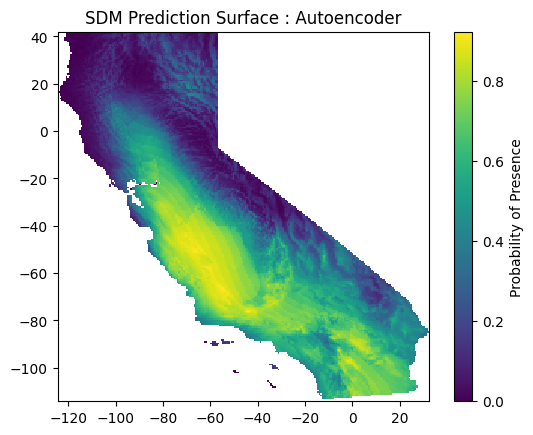

In [98]:
# Normalize the bioclimatic variables for the grid using the trained scaler
grid_bioclim_scaled = scaler.transform(grid_bioclim)

# predictions
predictions = classifier.predict(grid_bioclim_scaled).flatten()  # flatten the predictions

# empty array for the entire grid
full_grid_predictions = np.empty(mask.shape)
full_grid_predictions.fill(np.nan)  # Fill with NaNs

# Place predictions inside California
full_grid_predictions[mask] = predictions

# Plot (prediction surface + mask)
prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot the prediction surface
plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface : Autoencoder')
plt.show()

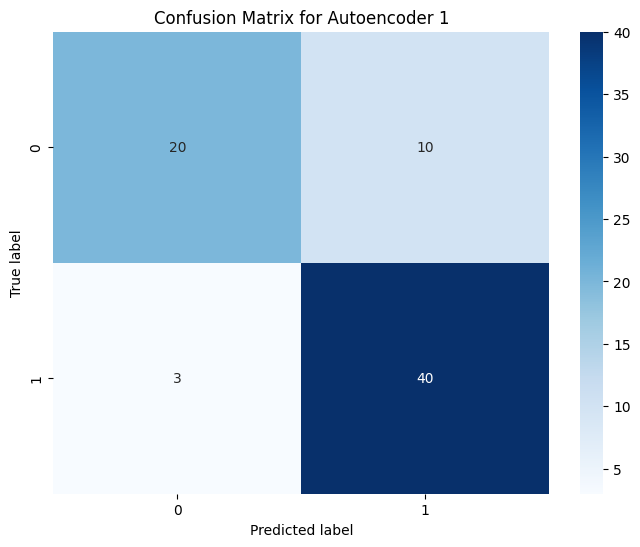

In [99]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Autoencoder 1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [100]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Autoencoder',
    type='Deep Learning',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

In [109]:
model_metrics

,Model Name,Type,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,Stacked Classifier,Traditional,-,-,0.931507,0.931034,0.900000,0.915254,0.962791,0.958904,0.976190,0.953488,0.964706,0.965891
1,Gradient Boosting,Traditional,-,-,0.945205,0.933333,0.933333,0.933333,0.989922,0.958904,0.976190,0.953488,0.964706,0.994574
2,XGBoost,Traditional,-,-,0.945205,0.933333,0.933333,0.933333,0.983721,0.945205,0.975610,0.930233,0.952381,0.996124
3,Random Forest,Traditional,-,-,0.958904,0.965517,0.933333,0.949153,0.991085,0.958904,0.976190,0.953488,0.964706,0.994961
4,Neural Network,Deep Learning,20,32,0.904110,0.848485,0.933333,0.888889,0.954264,0.931507,0.931818,0.953488,0.942529,0.975969
5,Multi Layer Perceptron,Deep Learning,20,32,0.917808,0.852941,0.966667,0.906250,0.972093,0.945205,0.914894,1.000000,0.955556,0.975969
6,Autoencoder,Deep Learning,20,32,0.821918,0.729730,0.900000,0.805970,0.883721,0.821918,0.800000,0.930233,0.860215,0.931008


##  Autoencoder 2

In [110]:
# Define encoder
input_data = Input(shape=(X_train.shape[1],))
encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(32, activation='relu')(encoded)

# Define decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

# Autoencoder
autoencoder = Model(input_data, decoded)

# Encoder - for dimensionality reduction
encoder = Model(input_data, encoded)

# Compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_val, X_val))

# Use the encoder to transform the data
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

# classifier with the encoded data shape
encoded_input = Input(shape=(32,))
classifier_layer = Dense(1, activation='sigmoid')(encoded_input)
classifier = Model(encoded_input, classifier_layer)

# Compile and train 
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Epoch 1/20


11/11 [==============================] - 1s 25ms/step - loss: 0.5845 - val_loss: 0.1184
Epoch 2/20
11/11 [==============================] - 0s 6ms/step - loss: -0.0969 - val_loss: -0.6898
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: -0.8587 - val_loss: -1.8090
Epoch 4/20
11/11 [==============================] - 0s 6ms/step - loss: -2.0557 - val_loss: -3.6320
Epoch 5/20
11/11 [==============================] - 0s 6ms/step - loss: -4.1111 - val_loss: -7.1409
Epoch 6/20
11/11 [==============================] - 0s 6ms/step - loss: -7.8516 - val_loss: -14.2178
Epoch 7/20
11/11 [==============================] - 0s 6ms/step - loss: -15.6281 - val_loss: -27.2333
Epoch 8/20
11/11 [==============================] - 0s 6ms/step - loss: -30.6194 - val_loss: -51.1469
Epoch 9/20
11/11 [==============================] - 0s 11ms/step - loss: -56.0169 - val_loss: -93.6382
Epoch 10/20
11/11 [==============================] - 0s 6ms/step - loss: -100.8670 - val_loss: -164.6010

In [111]:
history = classifier.fit(X_train_encoded, y_train, epochs=20, batch_size=32, validation_data=(X_val_encoded, y_val))

Epoch 1/20


11/11 [==============================] - 1s 27ms/step - loss: 18.0013 - accuracy: 0.7574 - val_loss: 18.7119 - val_accuracy: 0.7397
Epoch 2/20
11/11 [==============================] - 0s 6ms/step - loss: 16.2093 - accuracy: 0.7574 - val_loss: 16.7419 - val_accuracy: 0.7397
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 14.3747 - accuracy: 0.7574 - val_loss: 14.7578 - val_accuracy: 0.7397
Epoch 4/20
11/11 [==============================] - 0s 6ms/step - loss: 12.6566 - accuracy: 0.7574 - val_loss: 12.7635 - val_accuracy: 0.7397
Epoch 5/20
11/11 [==============================] - 0s 9ms/step - loss: 10.7926 - accuracy: 0.7574 - val_loss: 10.8709 - val_accuracy: 0.7260
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 9.0499 - accuracy: 0.7544 - val_loss: 8.9571 - val_accuracy: 0.7260
Epoch 7/20
11/11 [==============================] - 0s 6ms/step - loss: 7.4026 - accuracy: 0.7515 - val_loss: 7.1288 - val_accuracy: 0.6575
Epoch 8/20
11/11 [=

In [112]:
# Evaluate the model on the test data
test_loss, test_acc = classifier.evaluate(X_test_encoded, y_test)
print('Test accuracy:', test_acc)

# Predict on validation set with encoded data
y_pred_proba_val = classifier.predict(X_val_encoded)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set with encoded data
y_pred_proba_test = classifier.predict(X_test_encoded)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test = test_acc

3/3 [==============================] - 0s 4ms/step - loss: 0.4939 - accuracy: 0.8219
Test accuracy: 0.8219178318977356
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 1ms/step
Validation Accuracy: 0.8493150684931506
Validation Precision: 0.7567567567567568
Validation Recall   : 0.9333333333333333
Validation F1 Score : 0.835820895522388
Validation AUC      : 0.8922480620155039
Test Precision      : 0.8
Test Recall         : 0.9302325581395349
Test F1 Score       : 0.8602150537634408
Test AUC            : 0.8085271317829458


In [113]:
# # Normalize the bioclimatic variables for the grid using the trained scaler
# grid_bioclim_scaled = scaler.transform(grid_bioclim)

# # predictions
# predictions = classifier.predict(grid_bioclim_scaled).flatten()  # flatten the predictions

# # empty array for the entire grid
# full_grid_predictions = np.empty(mask.shape)
# full_grid_predictions.fill(np.nan)  # Fill with NaNs

# # Place predictions inside California
# full_grid_predictions[mask] = predictions

# # Plot (prediction surface + mask)
# prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# # Plot the prediction surface
# plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
# plt.colorbar(label='Probability of Presence')
# plt.title('SDM Prediction Surface : ANN Model')
# plt.show()

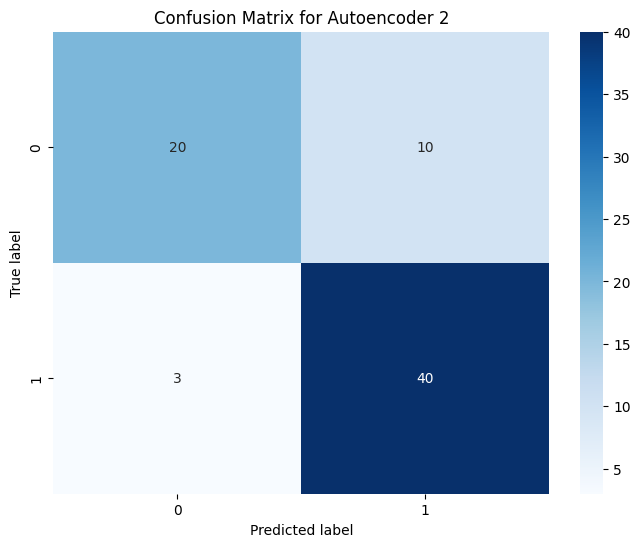

In [115]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Autoencoder 2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [116]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Autoencoder 2',
    type='Deep Learning',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Deep Belief Network (DBN)

In [117]:
# Constructing a DBN
def build_dbn_model(input_shape):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dbn_model = build_dbn_model((X_train.shape[1],))
dbn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 256)               5120      
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 46337 (181.00 KB)
Trainable params: 46337 (181.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [118]:
# Train and evaluate the model as usual
history = dbn_model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/40


11/11 [==============================] - 1s 35ms/step - loss: 0.4001 - accuracy: 0.8225 - val_loss: 0.3821 - val_accuracy: 0.8356
Epoch 2/40
11/11 [==============================] - 0s 7ms/step - loss: 0.3181 - accuracy: 0.8609 - val_loss: 0.3364 - val_accuracy: 0.8493
Epoch 3/40
11/11 [==============================] - 0s 7ms/step - loss: 0.2951 - accuracy: 0.8669 - val_loss: 0.4405 - val_accuracy: 0.8219
Epoch 4/40
11/11 [==============================] - 0s 6ms/step - loss: 0.2921 - accuracy: 0.8876 - val_loss: 0.3021 - val_accuracy: 0.8630
Epoch 5/40
11/11 [==============================] - 0s 6ms/step - loss: 0.2646 - accuracy: 0.8817 - val_loss: 0.3036 - val_accuracy: 0.8904
Epoch 6/40
11/11 [==============================] - 0s 6ms/step - loss: 0.2794 - accuracy: 0.8846 - val_loss: 0.3565 - val_accuracy: 0.8630
Epoch 7/40
11/11 [==============================] - 0s 6ms/step - loss: 0.2991 - accuracy: 0.8609 - val_loss: 0.3560 - val_accuracy: 0.8630
Epoch 8/40
11/11 [============

In [119]:
# Evaluate the model on the test data
test_loss, test_acc = dbn_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on validation set
y_pred_proba_val = dbn_model.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = dbn_model.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test=test_acc

3/3 [==============================] - 0s 4ms/step - loss: 3.2518 - accuracy: 0.8767
Test accuracy: 0.8767123222351074
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step
Validation Accuracy: 0.863013698630137
Validation Precision: 0.7777777777777778
Validation Recall   : 0.9333333333333333
Validation F1 Score : 0.8484848484848485
Validation AUC      : 0.8817829457364341
Test Precision      : 0.8269230769230769
Test Recall         : 1.0
Test F1 Score       : 0.9052631578947368
Test AUC            : 0.8682170542635658


 38/749 [>.............................] - ETA: 0s 

749/749 [==============================] - 1s 1ms/step


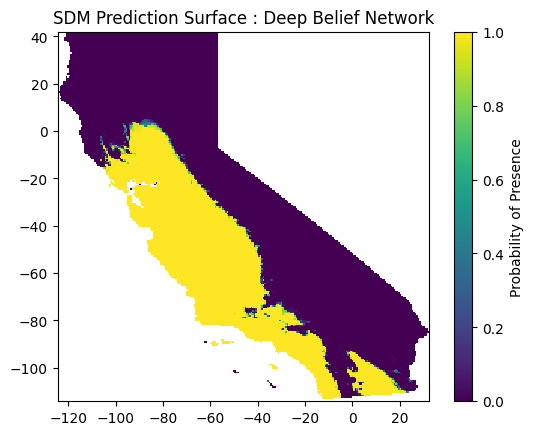

In [120]:
# Normalize the bioclimatic variables for the grid using the trained scaler
grid_bioclim_scaled = scaler.transform(grid_bioclim)

# predictions
predictions = dbn_model.predict(grid_bioclim_scaled).flatten()  # flatten the predictions

# empty array for the entire grid
full_grid_predictions = np.empty(mask.shape)
full_grid_predictions.fill(np.nan)  # Fill with NaNs

# Place predictions inside California
full_grid_predictions[mask] = predictions

# Plot (prediction surface + mask)
prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# Plot the prediction surface
plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface : Deep Belief Network')
plt.show()

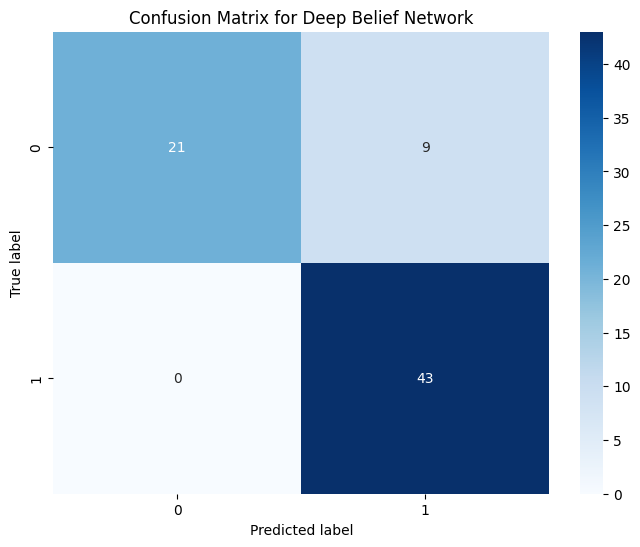

In [121]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Deep Belief Network')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [122]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Deep Belief Network',
    type='Deep Learning',
    epoch=40,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Gated Recurrent Unit (GRU)

In [123]:
# Reshape data for GRU input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [124]:
# Build GRU model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(50, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        GRU(50),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

gru_model = build_gru_model((1, X_train.shape[1]))
gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 50)             10650     
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 26001 (101.57 KB)
Trainable params: 26001 (101.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [125]:
history = gru_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, 
                        validation_data=(X_val_reshaped, y_val))

Epoch 1/20


11/11 [==============================] - 4s 185ms/step - loss: 0.6383 - accuracy: 0.8018 - val_loss: 0.5758 - val_accuracy: 0.8493
Epoch 2/20
11/11 [==============================] - 0s 16ms/step - loss: 0.5322 - accuracy: 0.8491 - val_loss: 0.4816 - val_accuracy: 0.8493
Epoch 3/20
11/11 [==============================] - 0s 11ms/step - loss: 0.4468 - accuracy: 0.8491 - val_loss: 0.4097 - val_accuracy: 0.8493
Epoch 4/20
11/11 [==============================] - 0s 10ms/step - loss: 0.3844 - accuracy: 0.8580 - val_loss: 0.3637 - val_accuracy: 0.8630
Epoch 5/20
11/11 [==============================] - 0s 11ms/step - loss: 0.3421 - accuracy: 0.8669 - val_loss: 0.3309 - val_accuracy: 0.8767
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 0.3145 - accuracy: 0.8846 - val_loss: 0.3031 - val_accuracy: 0.9041
Epoch 7/20
11/11 [==============================] - 0s 10ms/step - loss: 0.2920 - accuracy: 0.8905 - val_loss: 0.2845 - val_accuracy: 0.9041
Epoch 8/20
11/11 [=====

In [126]:

# Evaluate the model on the test data
test_loss, test_acc = gru_model.evaluate(X_test_reshaped, y_test)
print('Test accuracy:', test_acc)

# Predict on validation set
y_pred_proba_val = gru_model.predict(X_val_reshaped)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = gru_model.predict(X_test_reshaped)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test=test_acc

3/3 [==============================] - 0s 6ms/step - loss: 0.1907 - accuracy: 0.9452
Test accuracy: 0.9452054500579834


3/3 [==============================] - 0s 4ms/step
Validation Accuracy: 0.9315068493150684
Validation Precision: 0.9032258064516129
Validation Recall   : 0.9333333333333333
Validation F1 Score : 0.9180327868852459
Validation AUC      : 0.9651162790697674
Test Precision      : 0.9534883720930233
Test Recall         : 0.9534883720930233
Test F1 Score       : 0.9534883720930233
Test AUC            : 0.9736434108527132


In [127]:
# # Normalize the bioclimatic variables for the grid using the trained scaler
# grid_bioclim_scaled = scaler.transform(grid_bioclim)

# # Make predictions using the ANN model
# predictions = gru_model.predict(grid_bioclim_scaled).flatten()  # Flatten the predictions

# # Create an empty array for the entire grid
# full_grid_predictions = np.empty(mask.shape)
# full_grid_predictions.fill(np.nan)  # Fill with NaNs

# # Place predictions inside California
# full_grid_predictions[mask] = predictions

# # Reshape full_grid_predictions if necessary (it should already match the raster dimensions)
# prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# # Plot the prediction surface
# plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
# plt.colorbar(label='Probability of Presence')
# plt.title('SDM Prediction Surface : Gated Recurren Unit')
# plt.show()

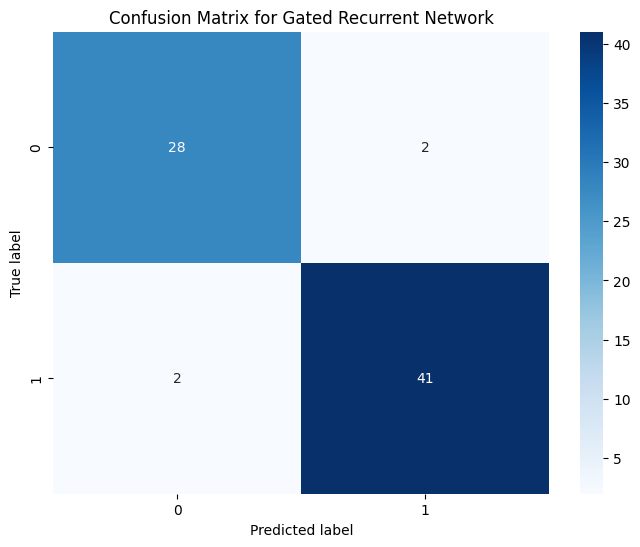

In [128]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Gated Recurrent Network')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [129]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Gated Recurrent Network',
    type='Deep Learning',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Transformer Model

In [130]:
# Reshape data for transformer input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [131]:
def build_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=2, key_dim=2)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    out1 = Flatten()(out1)  # Flatten the output
    out2 = Dense(64, activation='relu')(out1)
    outputs = Dense(1, activation='sigmoid')(out2)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

transformer_model = build_transformer_model((1, X_train.shape[1]))
transformer_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 1, 19)]              0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 1, 19)                335       ['input_11[0][0]',            
 iHeadAttention)                                                     'input_11[0][0]']            
                                                                                                  
 dropout_6 (Dropout)         (None, 1, 19)                0         ['multi_head_attention[0][0]']
                                                                                                  
 tf.__operators__.add (TFOp  (None, 1, 19)                0         ['input_11[0][0]',     

In [132]:
history = transformer_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, 
                        validation_data=(X_val_reshaped, y_val))

Epoch 1/20


11/11 [==============================] - 2s 71ms/step - loss: 0.6480 - accuracy: 0.6124 - val_loss: 0.4773 - val_accuracy: 0.8082
Epoch 2/20
11/11 [==============================] - 0s 15ms/step - loss: 0.4067 - accuracy: 0.8284 - val_loss: 0.3962 - val_accuracy: 0.8082
Epoch 3/20
11/11 [==============================] - 0s 19ms/step - loss: 0.3655 - accuracy: 0.8432 - val_loss: 0.3709 - val_accuracy: 0.7945
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 0.3393 - accuracy: 0.8462 - val_loss: 0.3490 - val_accuracy: 0.8356
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 0.3180 - accuracy: 0.8550 - val_loss: 0.3300 - val_accuracy: 0.8493
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 0.3005 - accuracy: 0.8609 - val_loss: 0.3144 - val_accuracy: 0.8630
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 0.2878 - accuracy: 0.8728 - val_loss: 0.3021 - val_accuracy: 0.9041
Epoch 8/20
11/11 [======

In [133]:

# Evaluate the model on the test data
test_loss, test_acc = transformer_model.evaluate(X_test_reshaped, y_test)
print('Test accuracy:', test_acc)

# Predict on validation set
y_pred_proba_val = transformer_model.predict(X_val_reshaped)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = transformer_model.predict(X_test_reshaped)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy:", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

accuracy_test=test_acc

3/3 [==============================] - 0s 6ms/step - loss: 0.1657 - accuracy: 0.9452
Test accuracy: 0.9452054500579834
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 10ms/step
Validation Accuracy: 0.9178082191780822
Validation Precision: 0.875
Validation Recall   : 0.9333333333333333
Validation F1 Score : 0.9032258064516129
Validation AUC      : 0.9565891472868218
Test Precision      : 0.9534883720930233
Test Recall         : 0.9534883720930233
Test F1 Score       : 0.9534883720930233
Test AUC            : 0.9852713178294574


In [134]:
# # Normalize the bioclimatic variables for the grid using the trained scaler
# grid_bioclim_scaled = scaler.transform(grid_bioclim)

# # Make predictions using the ANN model
# predictions = transformer_model.predict(grid_bioclim_scaled).flatten()  # Flatten the predictions

# # Create an empty array for the entire grid
# full_grid_predictions = np.empty(mask.shape)
# full_grid_predictions.fill(np.nan)  # Fill with NaNs

# # Place predictions inside California
# full_grid_predictions[mask] = predictions

# # Reshape full_grid_predictions if necessary (it should already match the raster dimensions)
# prediction_raster = full_grid_predictions.reshape(meta['height'], meta['width'])

# # Plot the prediction surface
# plt.imshow(prediction_raster, cmap='viridis', extent=src.bounds, interpolation='nearest')
# plt.colorbar(label='Probability of Presence')
# plt.title('SDM Prediction Surface : Gated Recurren Unit')
# plt.show()

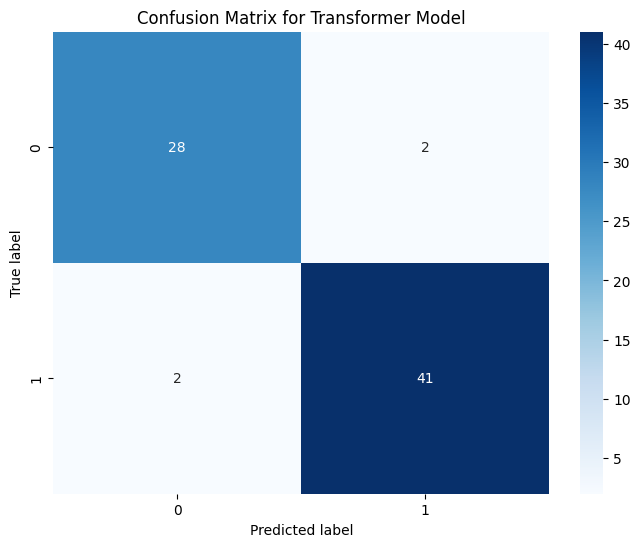

In [135]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Transformer Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [136]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Transformer Network',
    type='Deep Learning',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

In [137]:
model_metrics

,Model Name,Type,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,Stacked Classifier,Traditional,-,-,0.931507,0.931034,0.900000,0.915254,0.962791,0.958904,0.976190,0.953488,0.964706,0.965891
1,Gradient Boosting,Traditional,-,-,0.945205,0.933333,0.933333,0.933333,0.989922,0.958904,0.976190,0.953488,0.964706,0.994574
2,XGBoost,Traditional,-,-,0.945205,0.933333,0.933333,0.933333,0.983721,0.945205,0.975610,0.930233,0.952381,0.996124
3,Random Forest,Traditional,-,-,0.958904,0.965517,0.933333,0.949153,0.991085,0.958904,0.976190,0.953488,0.964706,0.994961
4,Neural Network,Deep Learning,20,32,0.904110,0.848485,0.933333,0.888889,0.954264,0.931507,0.931818,0.953488,0.942529,0.975969
5,Multi Layer Perceptron,Deep Learning,20,32,0.917808,0.852941,0.966667,0.906250,0.972093,0.945205,0.914894,1.000000,0.955556,0.975969
6,Autoencoder,Deep Learning,20,32,0.821918,0.729730,0.900000,0.805970,0.883721,0.821918,0.800000,0.930233,0.860215,0.931008
7,Autoencoder 2,Deep Learning,20,32,0.849315,0.756757,0.933333,0.835821,0.892248,0.821918,0.800000,0.930233,0.860215,0.808527
8,Deep Belief Network,Deep Learning,40,32,0.863014,0.777778,0.933333,0.848485,0.881783,0.876712,0.826923,1.000000,0.905263,0.868217
9,Gated Recurrent Network,Deep Learning,20,32,0.931507,0.903226,0.933333,0.918033,0.965116,0.945205,0.953488,0.953488,0.953488,0.973643


# `Convolutional Neural Networks`

## Data preprocessing

In [20]:
# For Plaeoclim bioclimatic data

x1,y1 = extract_windowed_data(df_presences, bioclim_data)
x2,y2 = extract_windowed_data(df_pseudoabsences, bioclim_data)

# Split data into training and other sets first 
X = np.vstack((x1, x2))
Y = np.concatenate((y1, y2))

print(len(X),len(Y))

Skipping crop presence point at (-114.504385685, 33.7213754525) due to being too close to the edge.
Skipping crop presence point at (-114.685746783, 33.6123476518) due to being too close to the edge.
Skipping crop presence point at (-114.533663682, 33.6120450267) due to being too close to the edge.
Skipping crop presence point at (-114.662444253, 33.507453432) due to being too close to the edge.
Skipping crop presence point at (-115.569369626, 33.325131833) due to being too close to the edge.
Skipping crop presence point at (-115.545457851, 33.2367652926) due to being too close to the edge.
Skipping crop presence point at (-115.413831521, 33.1801464963) due to being too close to the edge.
Skipping crop presence point at (-115.513509224, 33.1187605192) due to being too close to the edge.
Skipping crop presence point at (-115.362014984, 33.0968354349) due to being too close to the edge.
Skipping crop presence point at (-115.511868418, 33.0265213467) due to being too close to the edge.
Sk

In [21]:
# # For averaged out future bioclimatic data from TDS catalog

# years = [2040, 2041, 2042, 2043, 2044, 2045, 2046]  # List the years you have data for
# base_path = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/2010-2100/2040_43"  # Update this path to your files' location
# window_size = 32  # Define your desired window size
# presence_points = df_presences[['Longitude', 'Latitude']].copy() # DataFrame containing your presence points
# pseudo_absence_points = df_pseudoabsences[['Longitude', 'Latitude']].copy() # DataFrame containing your pseudo-absence points

# # Call the function
# x, y = extract_windowed_data(presence_points, pseudo_absence_points, years, base_path, window_size)
# print("\n")
# print(f"Number of crop presence points with large enough windows {len(x)} & corresponding labels {len(y)}")
# # print(len(x), len(y))

## Change train_test_split() input appropriately for the past (X,Y) or future bioclimatic data (x,y)  used

In [22]:

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalized the training set. Fit the scaler on X_train only
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, 19)  # Reshaped to 2D array for scaling
scaler.fit(X_train_reshaped)  

# Transform the training data
X_train_scaled = scaler.transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(X_train.shape)

# Transform the validation and test sets based on the scaler fitted on the training data
X_val_reshaped = X_val.reshape(-1, 19)
X_val_scaled = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled.reshape(X_val.shape)

X_test_reshaped = X_test.reshape(-1, 19)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Resized the images after scaling
X_train_resized = resize(X_train_scaled, (X_train_scaled.shape[0], 32, 32, 19))
X_val_resized = resize(X_val_scaled, (X_val_scaled.shape[0], 32, 32, 19))
X_test_resized = resize(X_test_scaled, (X_test_scaled.shape[0], 32, 32, 19))

# final variables for model training and evaluation
print(X_train_resized.shape, X_val_resized.shape, X_test_resized.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(290, 32, 32, 19) (62, 32, 32, 19) (63, 32, 32, 19)
(290,) (62,) (63,)


In [23]:
X_train = X_train_resized
X_val = X_val_resized
X_test = X_test_resized

In [24]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Load the California boundary shapefile
california_boundary = gpd.read_file('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/California_County_Boundaries.geojson')

# List of bioclimatic variable file paths
bioclim_files = [
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_1.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_2.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_3.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_4.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_5.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_6.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_7.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_8.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_9.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_10.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_11.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_12.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_13.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_14.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_15.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_16.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_17.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_18.tif',
    '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/CropSuitabilityModeling/data/bioclims/californiaclipped/bio_19.tif',

]

# all rasters have the same extent and resolution
with rasterio.open(bioclim_files[0]) as src:
    meta = src.meta
    california_boundary = california_boundary.to_crs(meta['crs'])
    mask = geometry_mask([geometry for geometry in california_boundary.geometry],
                         transform=src.transform, invert=True,
                         out_shape=(meta['height'], meta['width']))
    bioclim_data = np.stack([rasterio.open(f).read(1) for f in bioclim_files], axis=-1)

bioclim_data_reshaped = bioclim_data.reshape(-1, bioclim_data.shape[-1])  # Flatten the last dimension
bioclim_data_scaled = scaler.transform(bioclim_data_reshaped)  
bioclim_data_scaled = bioclim_data_scaled.reshape(bioclim_data.shape)  # Reshaped it back to the original shape

# windows of data for the CNN
windows_shape = (meta['height']//32, meta['width']//32, 32, 32, bioclim_data.shape[-1]) 
windows_strides = (bioclim_data.strides[0]*32, bioclim_data.strides[1]*32) + bioclim_data.strides  # Strides for moving the window
strided = np.lib.stride_tricks.as_strided(bioclim_data_scaled, shape=windows_shape, strides=windows_strides)

# Flatten the windows for prediction
windows_flattened = strided.reshape(-1, 32, 32, bioclim_data.shape[-1])

## LeNet-5 inspired model

In [25]:
model_lenet = Sequential()
model_lenet.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 19)))
model_lenet.add(MaxPooling2D(pool_size=(2, 2)))
model_lenet.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet.add(MaxPooling2D(pool_size=(2, 2)))
model_lenet.add(Flatten())
model_lenet.add(Dense(120, activation='relu'))
model_lenet.add(Dense(84, activation='relu'))
model_lenet.add(Dense(1, activation='sigmoid'))

model_lenet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lenet.summary()

2024-03-22 14:24:53.863591: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-22 14:24:53.864586: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-22 14:24:53.864624: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-22 14:24:53.865399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-22 14:24:53.866793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         2856      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [26]:
history=model_lenet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


2024-03-22 14:24:55.649824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 54ms/step - loss: 0.6987 - accuracy: 0.6172 - val_loss: 0.5388 - val_accuracy: 0.7258
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 0.5869 - accuracy: 0.7000 - val_loss: 0.6727 - val_accuracy: 0.5645
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 0.5698 - accuracy: 0.7414 - val_loss: 0.4298 - val_accuracy: 0.8226
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 0.5299 - accuracy: 0.7448 - val_loss: 0.4179 - val_accuracy: 0.8387
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 0.4734 - accuracy: 0.7966 - val_loss: 0.4713 - val_accuracy: 0.8226
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 0.5297 - accuracy: 0.8034 - val_loss: 0.5869 - val_accuracy: 0.7742
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 0.5159 - accuracy: 0.7828 - val_loss: 0.4626 - val_accuracy: 0.8226
Epoch 8/20
10/10 [======

In [27]:
# Evaluate the model_lenet on the test data
test_loss, test_acc = model_lenet.evaluate(X_test, y_test)

# Predict on validation set
y_pred_proba_val = model_lenet.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_lenet.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

2/2 [==============================] - 0s 49ms/step - loss: 0.5148 - accuracy: 0.8095


2/2 [==============================] - 0s 13ms/step
Validation Accuracy : 0.7903225806451613
Validation Precision: 0.84375
Validation Recall   : 0.7714285714285715
Validation F1 Score : 0.8059701492537314
Validation AUC      : 0.8952380952380953
Test accuracy       : 0.8095238208770752
Test Precision      : 0.8285714285714286
Test Recall         : 0.8285714285714286
Test F1 Score       : 0.8285714285714286
Test AUC            : 0.8520408163265306


2/2 [==============================] - 0s 28ms/step


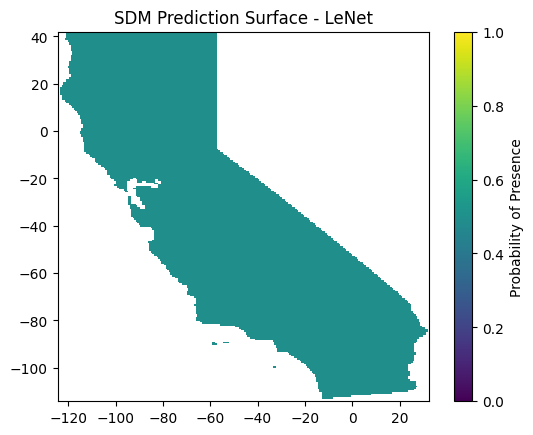

In [29]:
predictions_flattened = model_lenet.predict(windows_flattened).flatten()

# predictions
predictions_grid = np.zeros((meta['height']//32, meta['width']//32))
predictions_grid[:] = predictions_flattened.reshape(predictions_grid.shape)

# Upsample the grid back to the original resolution
prediction_raster = np.kron(predictions_grid, np.ones((32,32)))

# Apply the mask to get the final prediction surface within the California boundary
prediction_surface = np.full(mask.shape, np.nan)  
prediction_surface[mask] = prediction_raster.flatten()[:np.sum(mask)]  # Assign predictions within the mask

# Plot the prediction surface
# plt.figure(figsize=(10, 10))
plt.imshow(prediction_surface, cmap='viridis', extent=src.bounds, vmin=0, vmax=1)  # Set the color scale from 0 to 1
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface - LeNet')
plt.show()


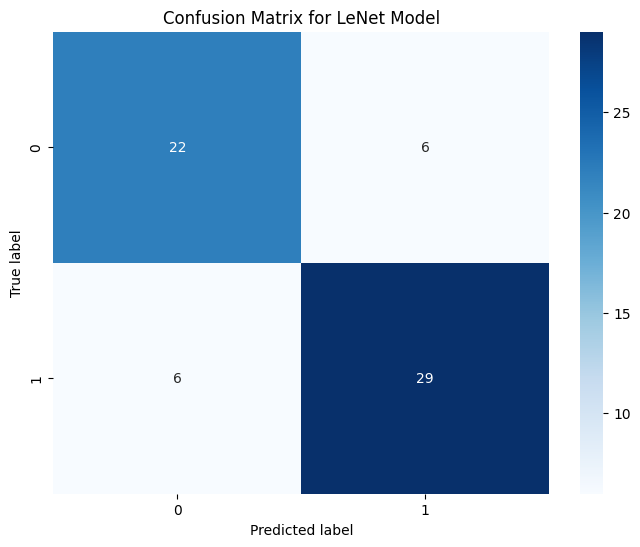

In [30]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LeNet Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='LeNet',
    type='Convolutional',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## VGG inspired model

In [32]:
model_vgg = Sequential()

# Block 1
model_vgg.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 19), padding='same'))
model_vgg.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D(pool_size=(2, 2)))

# Classification block
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(1, activation='sigmoid'))
                     
model_vgg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        11008     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                 

In [152]:
history=model_vgg.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


10/10 [==============================] - 6s 334ms/step - loss: 1.0357 - accuracy: 0.5379 - val_loss: 0.6298 - val_accuracy: 0.6129
Epoch 2/20
10/10 [==============================] - 0s 32ms/step - loss: 0.6400 - accuracy: 0.6448 - val_loss: 0.8077 - val_accuracy: 0.6129
Epoch 3/20
10/10 [==============================] - 0s 27ms/step - loss: 0.8444 - accuracy: 0.6414 - val_loss: 0.6433 - val_accuracy: 0.7097
Epoch 4/20
10/10 [==============================] - 0s 27ms/step - loss: 0.6449 - accuracy: 0.7448 - val_loss: 0.4241 - val_accuracy: 0.8387
Epoch 5/20
10/10 [==============================] - 0s 26ms/step - loss: 0.6243 - accuracy: 0.7034 - val_loss: 0.5445 - val_accuracy: 0.7419
Epoch 6/20
10/10 [==============================] - 0s 26ms/step - loss: 0.6396 - accuracy: 0.7138 - val_loss: 0.5532 - val_accuracy: 0.7903
Epoch 7/20
10/10 [==============================] - 0s 26ms/step - loss: 0.6225 - accuracy: 0.6897 - val_loss: 0.4744 - val_accuracy: 0.8387
Epoch 8/20
10/10 [=====

In [153]:

# Evaluate the model_vgg on the test data
test_loss, test_acc = model_vgg.evaluate(X_test, y_test)

# Predict on validation set
y_pred_proba_val = model_vgg.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_vgg.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



1/2 [==============>...............] - ETA: 0s - loss: 0.6651 - accuracy: 0.6250

2/2 [==============================] - 0s 45ms/step
Validation Accuracy : 0.7903225806451613
Validation Precision: 0.8928571428571429
Validation Recall   : 0.7142857142857143
Validation F1 Score : 0.7936507936507937
Validation AUC      : 0.8444444444444444
Test accuracy       : 0.7142857313156128
Test Precision      : 0.84
Test Recall         : 0.6
Test F1 Score       : 0.7000000000000001
Test AUC            : 0.8336734693877551


2/2 [==============================] - 0s 182ms/step


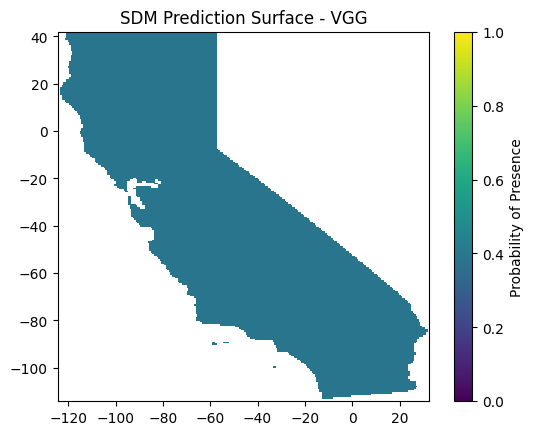

In [154]:
predictions_flattened = model_vgg.predict(windows_flattened).flatten()

# predictions
predictions_grid = np.zeros((meta['height']//32, meta['width']//32))
predictions_grid[:] = predictions_flattened.reshape(predictions_grid.shape)

# Upsample the grid back to the original resolution
prediction_raster = np.kron(predictions_grid, np.ones((32,32)))

# Apply the mask to get the final prediction surface within the California boundary
prediction_surface = np.full(mask.shape, np.nan)  
prediction_surface[mask] = prediction_raster.flatten()[:np.sum(mask)]  # Assign predictions within the mask

# Plot the prediction surface
# plt.figure(figsize=(10, 10))
plt.imshow(prediction_surface, cmap='viridis', extent=src.bounds, vmin=0, vmax=1)  # Set the color scale from 0 to 1
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface - VGG')
plt.show()


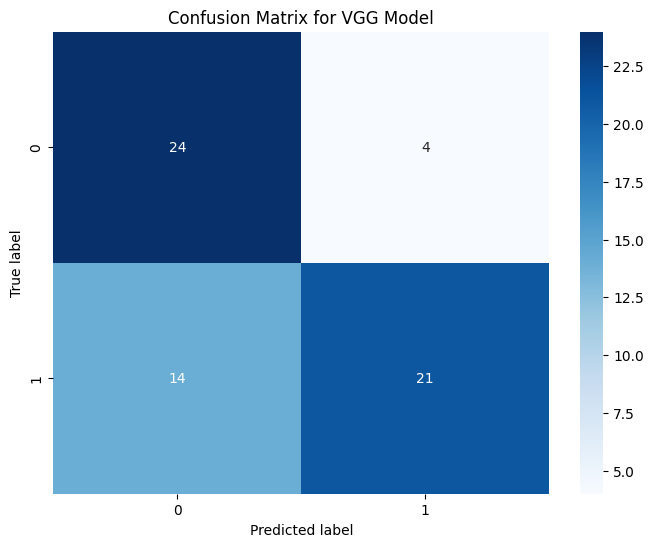

In [155]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for VGG Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [156]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='VGG',
    type='Convolutional',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## ResNet50 Architechture

In [157]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_shape=(32, 32, 19)):
    # Define the input
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='a')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc' + str(1), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

model_resnet50 = ResNet50(input_shape=(32, 32, 19))
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_resnet50.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 32, 32, 19)]         0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 19)           0         ['input_12[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 64)           59648     ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1[0][0]']        

In [158]:
history=model_resnet50.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


10/10 [==============================] - 7s 262ms/step - loss: 0.7289 - accuracy: 0.6966 - val_loss: 0.8573 - val_accuracy: 0.5645
Epoch 2/20
10/10 [==============================] - 0s 28ms/step - loss: 0.6251 - accuracy: 0.7483 - val_loss: 0.8670 - val_accuracy: 0.7258
Epoch 3/20
10/10 [==============================] - 0s 23ms/step - loss: 0.5985 - accuracy: 0.7759 - val_loss: 1.1982 - val_accuracy: 0.5806
Epoch 4/20
10/10 [==============================] - 0s 23ms/step - loss: 0.4209 - accuracy: 0.8069 - val_loss: 0.9410 - val_accuracy: 0.7581
Epoch 5/20
10/10 [==============================] - 0s 24ms/step - loss: 0.5114 - accuracy: 0.7793 - val_loss: 0.6464 - val_accuracy: 0.6935
Epoch 6/20
10/10 [==============================] - 0s 22ms/step - loss: 0.5241 - accuracy: 0.7448 - val_loss: 0.5431 - val_accuracy: 0.6935
Epoch 7/20
10/10 [==============================] - 0s 21ms/step - loss: 0.5490 - accuracy: 0.7448 - val_loss: 0.5885 - val_accuracy: 0.6452
Epoch 8/20
10/10 [=====

In [159]:

# Evaluate the model on the test data
test_loss, test_acc = model_resnet50.evaluate(X_test, y_test)

# Predict on validation set
y_pred_proba_val = model_resnet50.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_resnet50.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



1/2 [==============>...............] - ETA: 0s - loss: 1.0530 - accuracy: 0.5000

2/2 [==============================] - 0s 103ms/step
Validation Accuracy : 0.7419354838709677
Validation Precision: 0.8518518518518519
Validation Recall   : 0.6571428571428571
Validation F1 Score : 0.7419354838709677
Validation AUC      : 0.8063492063492064
Test accuracy       : 0.6190476417541504
Test Precision      : 0.7619047619047619
Test Recall         : 0.45714285714285713
Test F1 Score       : 0.5714285714285714
Test AUC            : 0.7071428571428571


2/2 [==============================] - 0s 61ms/step


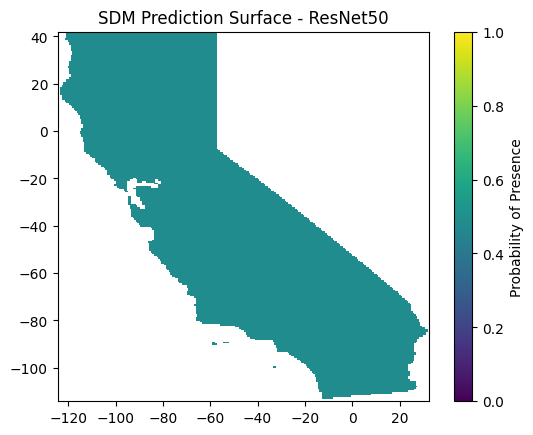

In [177]:
predictions_flattened = model_resnet50.predict(windows_flattened).flatten()

# predictions
predictions_grid = np.zeros((meta['height']//32, meta['width']//32))
predictions_grid[:] = predictions_flattened.reshape(predictions_grid.shape)

# Upsample the grid back to the original resolution
prediction_raster = np.kron(predictions_grid, np.ones((32,32)))

# Apply the mask to get the final prediction surface within the California boundary
prediction_surface = np.full(mask.shape, np.nan)  
prediction_surface[mask] = prediction_raster.flatten()[:np.sum(mask)]  # Assign predictions within the mask

# Plot the prediction surface
# plt.figure(figsize=(10, 10))
plt.imshow(prediction_surface, cmap='viridis', extent=src.bounds, vmin=0, vmax=1)  # Set the color scale from 0 to 1
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface - ResNet50')
plt.show()


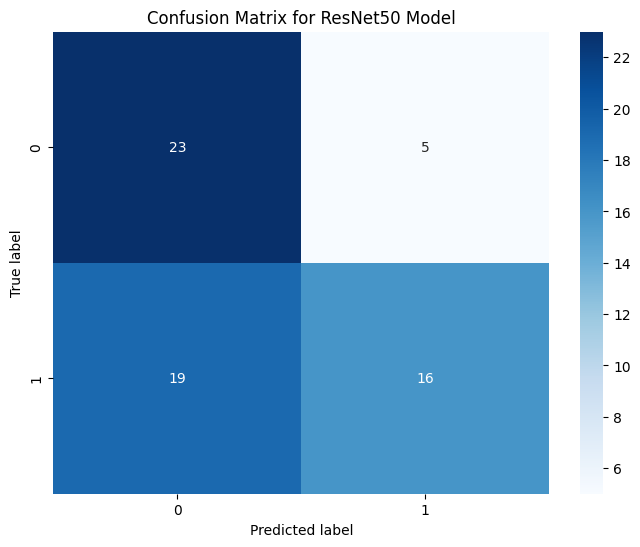

In [163]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for ResNet50 Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [164]:


model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='ResNet50',
    type='Convolutional',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Simplified ResNet50 Architechture

In [165]:

def simplified_identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Combine with shortcut path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def SimplifiedResNet(input_shape=(32, 32, 19)):
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(32, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = simplified_identity_block(X, 3, [32, 32, 128], stage=2, block='a')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc' + str(1), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='SimplifiedResNet')

    return model

model_simplified_resnet = SimplifiedResNet(input_shape=(32, 32, 19))
model_simplified_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_simplified_resnet.summary()


Model: "SimplifiedResNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 32, 32, 19)]         0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 38, 38, 19)           0         ['input_13[0][0]']            
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 32)           29824     ['zero_padding2d_1[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['conv1[0][0]']

In [166]:
history=model_simplified_resnet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


10/10 [==============================] - 2s 75ms/step - loss: 0.6527 - accuracy: 0.6966 - val_loss: 0.4538 - val_accuracy: 0.7903
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 0.4865 - accuracy: 0.7690 - val_loss: 0.4233 - val_accuracy: 0.8226
Epoch 3/20
10/10 [==============================] - 0s 14ms/step - loss: 0.4576 - accuracy: 0.7931 - val_loss: 0.4254 - val_accuracy: 0.8548
Epoch 4/20
10/10 [==============================] - 0s 12ms/step - loss: 0.4217 - accuracy: 0.8069 - val_loss: 0.4040 - val_accuracy: 0.8548
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 0.4075 - accuracy: 0.8069 - val_loss: 0.4471 - val_accuracy: 0.8065
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 0.4044 - accuracy: 0.8103 - val_loss: 0.4203 - val_accuracy: 0.8387
Epoch 7/20
10/10 [==============================] - 0s 16ms/step - loss: 0.3848 - accuracy: 0.8138 - val_loss: 0.4429 - val_accuracy: 0.7903
Epoch 8/20
10/10 [======

In [167]:

# Evaluate the model on the test data
test_loss, test_acc = model_simplified_resnet.evaluate(X_test, y_test)

# Predict on validation set
y_pred_proba_val = model_simplified_resnet.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_simplified_resnet.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

2/2 [==============================] - 0s 95ms/step - loss: 0.5215 - accuracy: 0.7302


2/2 [==============================] - 0s 55ms/step
Validation Accuracy : 0.8548387096774194
Validation Precision: 0.90625
Validation Recall   : 0.8285714285714286
Validation F1 Score : 0.8656716417910447
Validation AUC      : 0.8973544973544973
Test accuracy       : 0.7301587462425232
Test Precision      : 0.8
Test Recall         : 0.6857142857142857
Test F1 Score       : 0.7384615384615385
Test AUC            : 0.8255102040816327


2/2 [==============================] - 0s 69ms/step


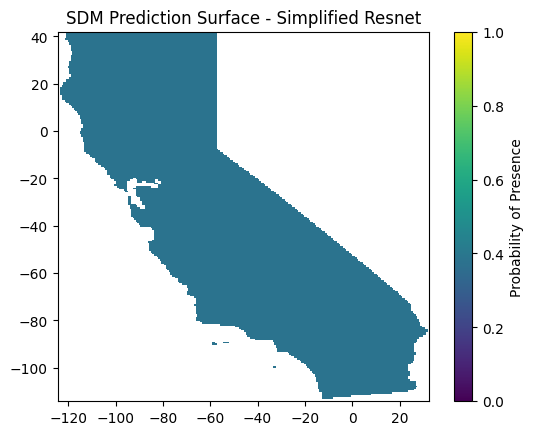

In [176]:
predictions_flattened = model_simplified_resnet.predict(windows_flattened).flatten()

# predictions
predictions_grid = np.zeros((meta['height']//32, meta['width']//32))
predictions_grid[:] = predictions_flattened.reshape(predictions_grid.shape)

# Upsample the grid back to the original resolution
prediction_raster = np.kron(predictions_grid, np.ones((32,32)))

# Apply the mask to get the final prediction surface within the California boundary
prediction_surface = np.full(mask.shape, np.nan)  
prediction_surface[mask] = prediction_raster.flatten()[:np.sum(mask)]  # Assign predictions within the mask

# Plot the prediction surface
# plt.figure(figsize=(10, 10))
plt.imshow(prediction_surface, cmap='viridis', extent=src.bounds, vmin=0, vmax=1)  # Set the color scale from 0 to 1
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface - Simplified Resnet')
plt.show()


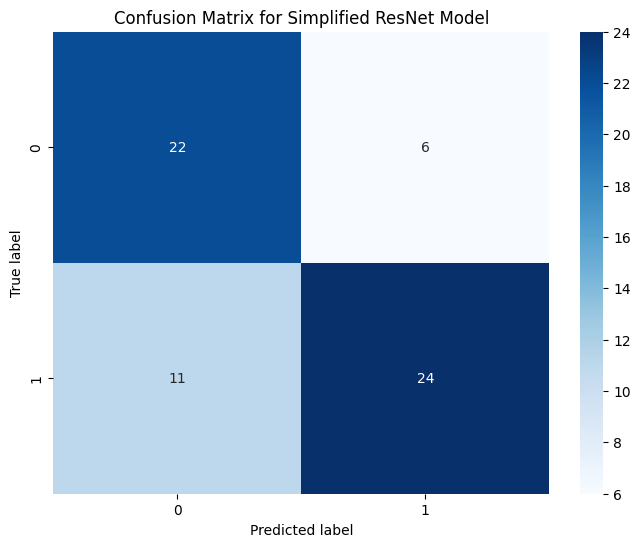

In [169]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Simplified ResNet Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [170]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='ResNet50_Simpl',
    type='Convolutional',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Inception Inspired Model

In [178]:
def inception_block(X, filters):
    # 1x1 conv
    conv1 = Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(X)

    # 3x3 conv
    conv3 = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(X)

    # 5x5 conv
    conv5 = Conv2D(filters=filters, kernel_size=(5, 5), padding='same', activation='relu')(X)

    # 3x3 max pooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(X)

    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)

    return layer_out

def InceptionNet(input_shape):
    X_input = Input(input_shape)
    
    # Inception blocks
    X = inception_block(X_input, 32)
    X = inception_block(X, 64)
    X = MaxPooling2D(pool_size=(4, 4))(X)
    
    # Flatten and fully connected layer
    X = Flatten()(X)
    X = Dense(120, activation='relu')(X)
    X = Dense(84, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='InceptionNet')
    
    return model

model_inception = InceptionNet(input_shape=(32, 32, 19))
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_inception.summary()


Model: "InceptionNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 32, 32, 19)]         0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 32, 32, 32)           640       ['input_15[0][0]']            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 32, 32, 32)           5504      ['input_15[0][0]']            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 32, 32, 32)           15232     ['input_15[0][0]']            
                                                                                       

In [179]:
history=model_inception.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


10/10 [==============================] - 2s 137ms/step - loss: 3.5454 - accuracy: 0.6828 - val_loss: 1.3487 - val_accuracy: 0.6774
Epoch 2/20
10/10 [==============================] - 1s 76ms/step - loss: 1.9559 - accuracy: 0.7414 - val_loss: 0.7925 - val_accuracy: 0.7097
Epoch 3/20
10/10 [==============================] - 1s 57ms/step - loss: 1.0054 - accuracy: 0.7517 - val_loss: 0.5957 - val_accuracy: 0.7742
Epoch 4/20
10/10 [==============================] - 1s 56ms/step - loss: 0.7386 - accuracy: 0.7621 - val_loss: 0.6254 - val_accuracy: 0.7742
Epoch 5/20
10/10 [==============================] - 1s 59ms/step - loss: 0.7561 - accuracy: 0.7276 - val_loss: 0.9143 - val_accuracy: 0.7097
Epoch 6/20
10/10 [==============================] - 1s 61ms/step - loss: 1.1514 - accuracy: 0.7517 - val_loss: 0.6222 - val_accuracy: 0.8226
Epoch 7/20
10/10 [==============================] - 1s 60ms/step - loss: 0.6618 - accuracy: 0.7724 - val_loss: 0.4507 - val_accuracy: 0.8226
Epoch 8/20
10/10 [=====

In [180]:

# Evaluate the model on the test data
test_loss, test_acc = model_inception.evaluate(X_test, y_test)

# Predict on validation set
y_pred_proba_val = model_inception.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_inception.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



2/2 [==============================] - 0s 144ms/step - loss: 1.0582 - accuracy: 0.7460


2/2 [==============================] - 0s 68ms/step
Validation Accuracy : 0.7258064516129032
Validation Precision: 0.7142857142857143
Validation Recall   : 0.8571428571428571
Validation F1 Score : 0.7792207792207793
Validation AUC      : 0.7968253968253969
Test accuracy       : 0.7460317611694336
Test Precision      : 0.7209302325581395
Test Recall         : 0.8857142857142857
Test F1 Score       : 0.7948717948717948
Test AUC            : 0.8071428571428572


2/2 [==============================] - 0s 88ms/step


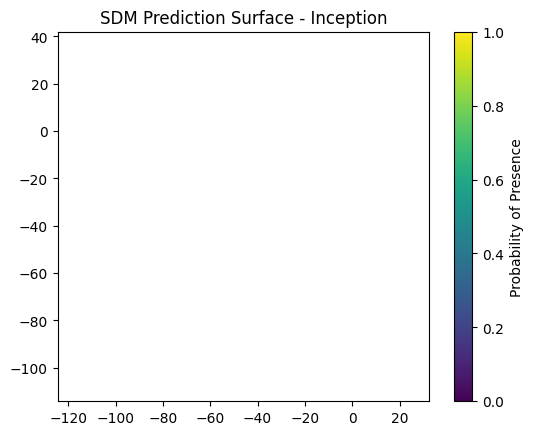

In [181]:
predictions_flattened = model_inception.predict(windows_flattened).flatten()

# predictions
predictions_grid = np.zeros((meta['height']//32, meta['width']//32))
predictions_grid[:] = predictions_flattened.reshape(predictions_grid.shape)

# Upsample the grid back to the original resolution
prediction_raster = np.kron(predictions_grid, np.ones((32,32)))

# Apply the mask to get the final prediction surface within the California boundary
prediction_surface = np.full(mask.shape, np.nan)  
prediction_surface[mask] = prediction_raster.flatten()[:np.sum(mask)]  # Assign predictions within the mask

# Plot the prediction surface
# plt.figure(figsize=(10, 10))
plt.imshow(prediction_surface, cmap='viridis', extent=src.bounds, vmin=0, vmax=1)  # Set the color scale from 0 to 1
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface - Inception')
plt.show()


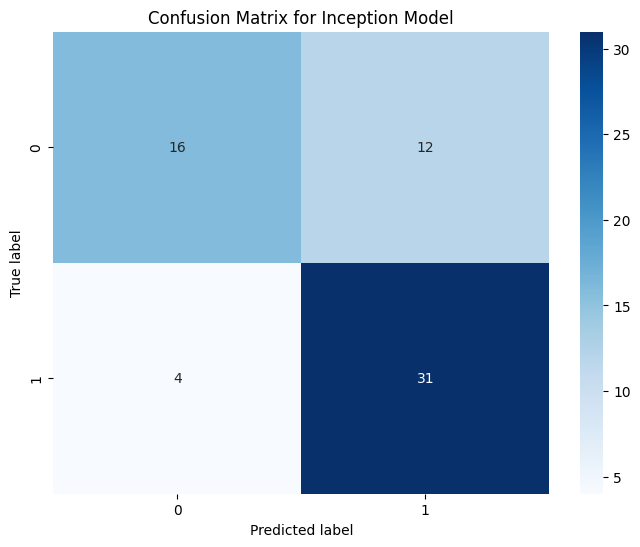

In [182]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Inception Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [183]:
model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Inception',
    type='Convolutional',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

## Alexnet Insipired Model

In [34]:
model_alexnet = Sequential()

# Assuming input_shape is (32, 32, 19) based on your dataset
input_shape = (32, 32, 19)

# Block 1
model_alexnet.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape, padding='same'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 2
model_alexnet.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 3
model_alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model_alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))

# Classification block
model_alexnet.add(Flatten())
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(1, activation='sigmoid'))

model_alexnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_alexnet.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 8, 8, 96)          220800    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 96)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 2, 2, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 384)         885120    
                                                                 
 conv2d_12 (Conv2D)          (None, 2, 2, 384)        

In [35]:
history=model_alexnet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


10/10 [==============================] - 2s 84ms/step - loss: 1.2565 - accuracy: 0.5034 - val_loss: 0.5373 - val_accuracy: 0.7419
Epoch 2/20
10/10 [==============================] - 0s 34ms/step - loss: 0.6742 - accuracy: 0.6552 - val_loss: 0.4914 - val_accuracy: 0.7581
Epoch 3/20
10/10 [==============================] - 0s 32ms/step - loss: 0.6039 - accuracy: 0.6552 - val_loss: 0.5067 - val_accuracy: 0.6129
Epoch 4/20
10/10 [==============================] - 0s 32ms/step - loss: 0.6010 - accuracy: 0.6552 - val_loss: 0.5233 - val_accuracy: 0.6129
Epoch 5/20
10/10 [==============================] - 0s 33ms/step - loss: 0.5912 - accuracy: 0.5931 - val_loss: 0.5357 - val_accuracy: 0.6290
Epoch 6/20
10/10 [==============================] - 0s 32ms/step - loss: 0.6017 - accuracy: 0.6586 - val_loss: 0.5177 - val_accuracy: 0.7258
Epoch 7/20
10/10 [==============================] - 0s 38ms/step - loss: 0.6195 - accuracy: 0.6241 - val_loss: 0.5386 - val_accuracy: 0.8065
Epoch 8/20
10/10 [======

In [37]:

# Evaluate the model on the test data
test_loss, test_acc = model_alexnet.evaluate(X_test, y_test)

# Predict on validation set
y_pred_proba_val = model_alexnet.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_alexnet.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='AlexNet',
    type='Convolutional',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 119ms/step


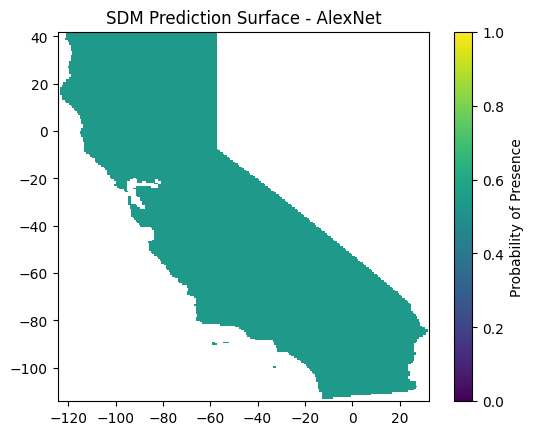

In [38]:
predictions_flattened = model_alexnet.predict(windows_flattened).flatten()

# predictions
predictions_grid = np.zeros((meta['height']//32, meta['width']//32))
predictions_grid[:] = predictions_flattened.reshape(predictions_grid.shape)

# Upsample the grid back to the original resolution
prediction_raster = np.kron(predictions_grid, np.ones((32,32)))

# Apply the mask to get the final prediction surface within the California boundary
prediction_surface = np.full(mask.shape, np.nan)  
prediction_surface[mask] = prediction_raster.flatten()[:np.sum(mask)]  # Assign predictions within the mask

# Plot the prediction surface
# plt.figure(figsize=(10, 10))
plt.imshow(prediction_surface, cmap='viridis', extent=src.bounds, vmin=0, vmax=1)  # Set the color scale from 0 to 1
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface - AlexNet')
plt.show()


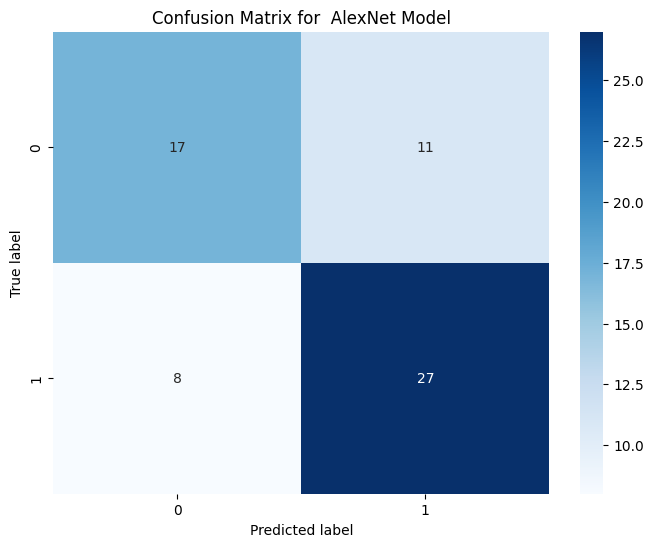

In [39]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for  AlexNet Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Mobilenet Inspired Model

In [189]:
model_mobilenet = Sequential()

# Depthwise Separable Convolution Block 1
model_mobilenet.add(DepthwiseConv2D(kernel_size=(3, 3), input_shape=(32, 32, 19), activation='relu', padding='same'))
model_mobilenet.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
model_mobilenet.add(MaxPooling2D(pool_size=(2, 2)))

# Depthwise Separable Convolution Block 2
model_mobilenet.add(DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same'))
model_mobilenet.add(Conv2D(128, (1, 1), activation='relu', padding='same'))
model_mobilenet.add(MaxPooling2D(pool_size=(2, 2)))

# Depthwise Separable Convolution Block 3
model_mobilenet.add(DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same'))
model_mobilenet.add(Conv2D(128, (1, 1), activation='relu', padding='same'))
model_mobilenet.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the network before the fully connected layers
model_mobilenet.add(Flatten())

# Fully Connected Layers
model_mobilenet.add(Dense(1024, activation='relu'))
model_mobilenet.add(Dropout(0.5))
model_mobilenet.add(Dense(1024, activation='relu'))
model_mobilenet.add(Dropout(0.5))

# Output Layer
model_mobilenet.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwis  (None, 32, 32, 19)        190       
 eConv2D)                                                        
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        1280      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 depthwise_conv2d_1 (Depthw  (None, 16, 16, 64)        640       
 iseConv2D)                                                      
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 128)       8320      
                                                      

In [190]:
history=model_mobilenet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


10/10 [==============================] - 4s 139ms/step - loss: 0.6864 - accuracy: 0.5069 - val_loss: 0.6646 - val_accuracy: 0.5645
Epoch 2/20
10/10 [==============================] - 0s 21ms/step - loss: 0.6995 - accuracy: 0.5690 - val_loss: 0.6465 - val_accuracy: 0.6935
Epoch 3/20
10/10 [==============================] - 0s 19ms/step - loss: 0.6479 - accuracy: 0.6586 - val_loss: 0.5557 - val_accuracy: 0.6774
Epoch 4/20
10/10 [==============================] - 0s 28ms/step - loss: 0.5508 - accuracy: 0.7276 - val_loss: 0.4471 - val_accuracy: 0.8387
Epoch 5/20
10/10 [==============================] - 0s 21ms/step - loss: 0.6080 - accuracy: 0.7034 - val_loss: 0.4572 - val_accuracy: 0.8387
Epoch 6/20
10/10 [==============================] - 0s 20ms/step - loss: 0.5069 - accuracy: 0.7621 - val_loss: 0.5122 - val_accuracy: 0.7419
Epoch 7/20
10/10 [==============================] - 0s 38ms/step - loss: 0.5440 - accuracy: 0.7241 - val_loss: 0.5490 - val_accuracy: 0.7419
Epoch 8/20
10/10 [=====

In [191]:

# Evaluate the model on the test data
test_loss, test_acc = model_mobilenet.evaluate(X_test, y_test)

# Predict on validation set
y_pred_proba_val = model_mobilenet.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model_mobilenet.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



2/2 [==============================] - 0s 124ms/step - loss: 0.5334 - accuracy: 0.6349


2/2 [==============================] - 0s 76ms/step
Validation Accuracy : 0.7419354838709677
Validation Precision: 0.9130434782608695
Validation Recall   : 0.6
Validation F1 Score : 0.7241379310344828
Validation AUC      : 0.8677248677248677
Test accuracy       : 0.6349206566810608
Test Precision      : 0.7727272727272727
Test Recall         : 0.4857142857142857
Test F1 Score       : 0.5964912280701754
Test AUC            : 0.8479591836734693


2/2 [==============================] - 0s 146ms/step


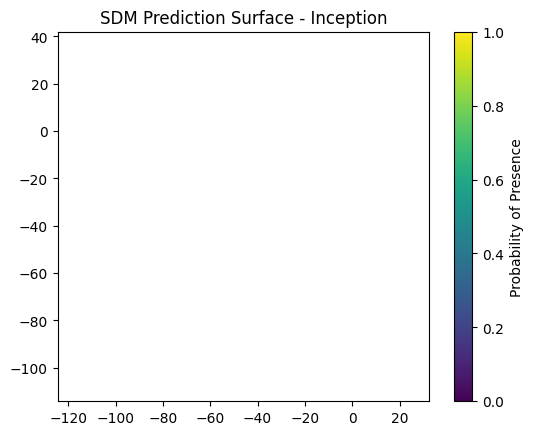

In [192]:
predictions_flattened = model_mobilenet.predict(windows_flattened).flatten()

# predictions
predictions_grid = np.zeros((meta['height']//32, meta['width']//32))
predictions_grid[:] = predictions_flattened.reshape(predictions_grid.shape)

# Upsample the grid back to the original resolution
prediction_raster = np.kron(predictions_grid, np.ones((32,32)))

# Apply the mask to get the final prediction surface within the California boundary
prediction_surface = np.full(mask.shape, np.nan)  
prediction_surface[mask] = prediction_raster.flatten()[:np.sum(mask)]  # Assign predictions within the mask

# Plot the prediction surface
# plt.figure(figsize=(10, 10))
plt.imshow(prediction_surface, cmap='viridis', extent=src.bounds, vmin=0, vmax=1)  # Set the color scale from 0 to 1
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface - Inception')
plt.show()


In [193]:


model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='MobileNet',
    type='Convolutional',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

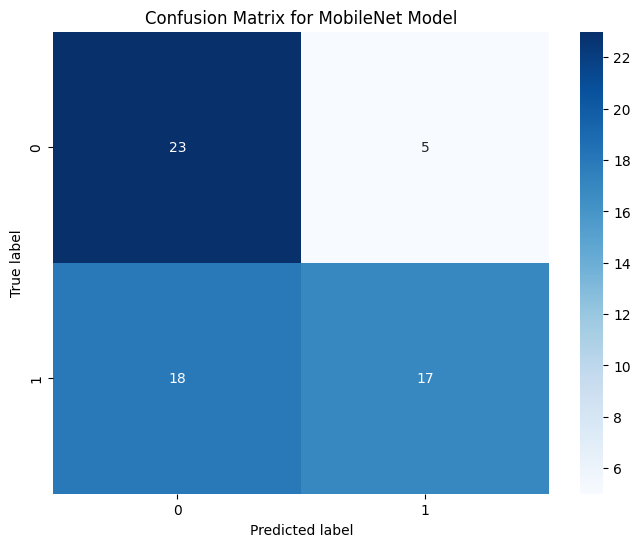

In [194]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for MobileNet Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Custom CNN Architecture

In [40]:
custom_cnn_model = Sequential()

# First Convolutional Block with Batch Normalization
custom_cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 19)))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(MaxPooling2D((2, 2)))
custom_cnn_model.add(Dropout(0.2))

# Second Convolutional Block
custom_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(MaxPooling2D((2, 2)))
custom_cnn_model.add(Dropout(0.3))

# Third Convolutional Block
custom_cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(MaxPooling2D((2, 2)))
custom_cnn_model.add(Dropout(0.4))

# Flatten and Dense Layers
custom_cnn_model.add(Flatten())
custom_cnn_model.add(Dense(128, activation='relu'))
custom_cnn_model.add(BatchNormalization())
custom_cnn_model.add(Dropout(0.5))
custom_cnn_model.add(Dense(1, activation='sigmoid'))  # For binary classification

custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

custom_cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        5504      
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 64)       

In [41]:
history=custom_cnn_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


10/10 [==============================] - 2s 83ms/step - loss: 0.8073 - accuracy: 0.6000 - val_loss: 0.5277 - val_accuracy: 0.6935
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6563 - accuracy: 0.6931 - val_loss: 0.5510 - val_accuracy: 0.6290
Epoch 3/20
10/10 [==============================] - 0s 17ms/step - loss: 0.6446 - accuracy: 0.7034 - val_loss: 0.4830 - val_accuracy: 0.7903
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 0.6262 - accuracy: 0.7207 - val_loss: 0.4816 - val_accuracy: 0.8065
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 0.5621 - accuracy: 0.7103 - val_loss: 0.4824 - val_accuracy: 0.8387
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 0.5458 - accuracy: 0.7621 - val_loss: 0.4800 - val_accuracy: 0.8065
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 0.5718 - accuracy: 0.7138 - val_loss: 0.5158 - val_accuracy: 0.8226
Epoch 8/20
10/10 [======

In [45]:

# Evaluate the model on the test data
test_loss, test_acc = custom_cnn_model.evaluate(X_test, y_test)

# Predict on validation set
y_pred_proba_val = custom_cnn_model.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = custom_cnn_model.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)



model_metrics = append_model_metrics(
    metrics_df=model_metrics,
    name='Custom CNN',
    type='Convolutional',
    epoch=20,
    batch_size=32,
    accuracy_val=accuracy_val,
    precision_val=precision_val,
    recall_val=recall_val,
    f1score_val=f1score_val,
    auc_val=auc_val,
    accuracy_test=accuracy_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1score_test=f1score_test,
    auc_test=auc_test
)

2/2 [==============================] - 0s 59ms/step


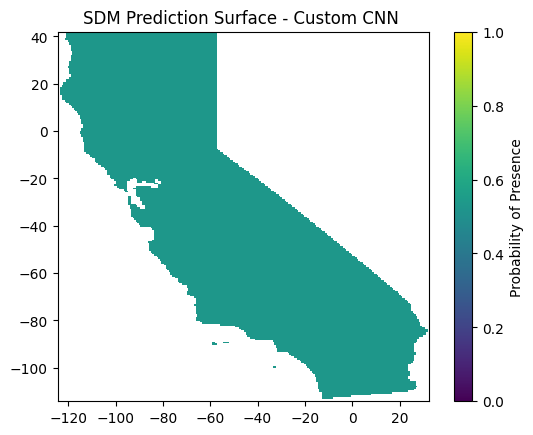

In [43]:
predictions_flattened = custom_cnn_model.predict(windows_flattened).flatten()

# predictions
predictions_grid = np.zeros((meta['height']//32, meta['width']//32))
predictions_grid[:] = predictions_flattened.reshape(predictions_grid.shape)

# Upsample the grid back to the original resolution
prediction_raster = np.kron(predictions_grid, np.ones((32,32)))

# Apply the mask to get the final prediction surface within the California boundary
prediction_surface = np.full(mask.shape, np.nan)  
prediction_surface[mask] = prediction_raster.flatten()[:np.sum(mask)]  # Assign predictions within the mask

# Plot the prediction surface
# plt.figure(figsize=(10, 10))
plt.imshow(prediction_surface, cmap='viridis', extent=src.bounds, vmin=0, vmax=1)  # Set the color scale from 0 to 1
plt.colorbar(label='Probability of Presence')
plt.title('SDM Prediction Surface - Custom CNN ')
plt.show()


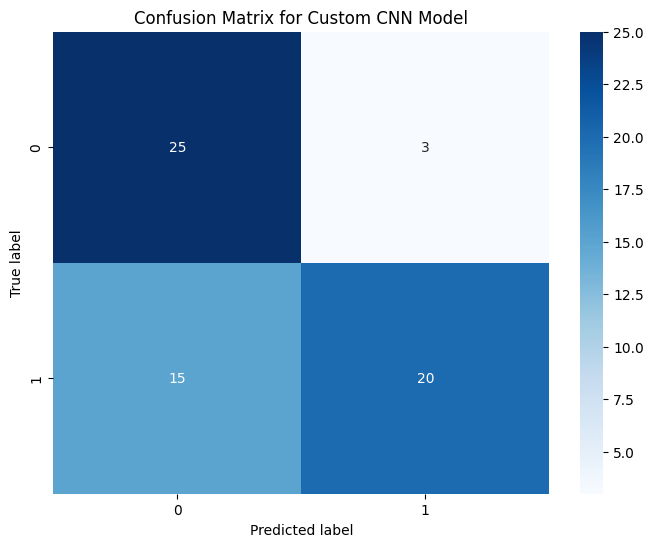

In [44]:
# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Custom CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Results

In [200]:
# ! pip install Jinja2

In [204]:
model_metrics.style.apply(lambda s: ['background-color: green' if (s.name == 'Validation F1 Score' and v > 0.8) or 
                                                 (s.name == 'Test F1 Score' and v > 0.8) else 'background-color: brown' for v in s], 
                                                 subset=['Validation F1 Score', 'Test F1 Score'])

# model_metrics.style.apply(lambda s: ['background-color: green' if (s.name == 'Validation AUC' and v > 0.9) or 
#                                                  (s.name == 'Test AUC' and v > 0.9) else 'background-color: brown' for v in s], 
#                                                  subset=['Validation AUC', 'Test AUC'])

# model_metrics.style.apply(lambda s: ['background-color: red' if v < 0.5 else 
#                                                  'background-color: blue' if 0.5 <= v <= 0.8 else 
#                                                  'background-color: green' if v > 0.8 else '' 
#                                                  for v in s], subset=['Test Accuracy'])


,Model Name,Type,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
0,Stacked Classifier,Traditional,-,-,0.931507,0.931034,0.900000,0.915254,0.962791,0.958904,0.976190,0.953488,0.964706,0.965891
1,Gradient Boosting,Traditional,-,-,0.945205,0.933333,0.933333,0.933333,0.989922,0.958904,0.976190,0.953488,0.964706,0.994574
2,XGBoost,Traditional,-,-,0.945205,0.933333,0.933333,0.933333,0.983721,0.945205,0.975610,0.930233,0.952381,0.996124
3,Random Forest,Traditional,-,-,0.958904,0.965517,0.933333,0.949153,0.991085,0.958904,0.976190,0.953488,0.964706,0.994961
4,Neural Network,Deep Learning,20,32,0.904110,0.848485,0.933333,0.888889,0.954264,0.931507,0.931818,0.953488,0.942529,0.975969
5,Multi Layer Perceptron,Deep Learning,20,32,0.917808,0.852941,0.966667,0.906250,0.972093,0.945205,0.914894,1.000000,0.955556,0.975969
6,Autoencoder,Deep Learning,20,32,0.821918,0.729730,0.900000,0.805970,0.883721,0.821918,0.800000,0.930233,0.860215,0.931008
7,Autoencoder 2,Deep Learning,20,32,0.849315,0.756757,0.933333,0.835821,0.892248,0.821918,0.800000,0.930233,0.860215,0.808527
8,Deep Belief Network,Deep Learning,40,32,0.863014,0.777778,0.933333,0.848485,0.881783,0.876712,0.826923,1.000000,0.905263,0.868217
9,Gated Recurrent Network,Deep Learning,20,32,0.931507,0.903226,0.933333,0.918033,0.965116,0.945205,0.953488,0.953488,0.953488,0.973643


In [205]:
# model_metrics.drop(index=[11,12,13,14,15,16,17,18,19], inplace = True)

# Ensemble Predictions

In [206]:
model_metrics[model_metrics['Model Name'].isin(['ResNet50', 'Inception', 'Custom CNN', 'MobileNet'])]

,Model Name,Type,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
13,ResNet50,Convolutional,20,32,0.741935,0.851852,0.657143,0.741935,0.806349,0.619048,0.761905,0.457143,0.571429,0.707143
15,Inception,Convolutional,20,32,0.725806,0.714286,0.857143,0.779221,0.796825,0.746032,0.720930,0.885714,0.794872,0.807143
17,MobileNet,Convolutional,20,32,0.741935,0.913043,0.600000,0.724138,0.867725,0.634921,0.772727,0.485714,0.596491,0.847959
18,Custom CNN,Convolutional,20,32,0.741935,0.686275,1.000000,0.813953,0.923810,0.698413,0.648148,1.000000,0.786517,0.878571


In [207]:
def weighted_ensemble_predictions(models, weights, X):
    weighted_predictions = np.zeros((X.shape[0], 1))  # Initialize an array to store weighted predictions

    for model, weight in zip(models, weights):
        predictions = model.predict(X)
        weighted_predictions += weight * predictions

    # Normalize by sum of weights
    weighted_predictions /= sum(weights)
    return weighted_predictions

# Assigning weights based on test accuracies
weights = [0.926686, 0.910278, 0.879346]  

# Models list
models = [model_resnet50, model_inception, custom_cnn_model]

# Making weighted ensemble predictions
weighted_ensemble_preds = weighted_ensemble_predictions(models, weights, X_test)

# Convert weighted probabilities to binary predictions
weighted_ensemble_binary_preds = (weighted_ensemble_preds >= 0.5).astype(int)

2/2 [==============================] - 0s 278ms/step


2/2 [==============================] - 0s 63ms/step


In [208]:
# Evaluation on Test Set for Weighted Ensemble
accuracy_test = accuracy_score(y_test, weighted_ensemble_binary_preds)
precision_test = precision_score(y_test, weighted_ensemble_binary_preds)
recall_test = recall_score(y_test, weighted_ensemble_binary_preds)
f1score_test = f1_score(y_test, weighted_ensemble_binary_preds)
auc_test = roc_auc_score(y_test, weighted_ensemble_preds)  # Use probabilities, not binary predictions

print('Weighted Ensemble Test Accuracy :', accuracy_test)
print('Weighted Ensemble Test Precision:', precision_test)
print('Weighted Ensemble Test Recall   :', recall_test)
print('Weighted Ensemble Test F1 Score :', f1score_test)
print('Weighted Ensemble Test AUC      :', auc_test)


Weighted Ensemble Test Accuracy : 0.7301587301587301
Weighted Ensemble Test Precision: 0.7045454545454546
Weighted Ensemble Test Recall   : 0.8857142857142857
Weighted Ensemble Test F1 Score : 0.7848101265822784
Weighted Ensemble Test AUC      : 0.810204081632653


In [209]:
model_metrics[model_metrics['Model Name']=='Multi Layer Perceptron']

,Model Name,Type,Epoch,Batch Size,Validation Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC
5,Multi Layer Perceptron,Deep Learning,20,32,0.917808,0.852941,0.966667,0.90625,0.972093,0.945205,0.914894,1.0,0.955556,0.975969


In [210]:
end_time = time.time()
execution_time = end_time - start_time

print("Execution time for the model iteration: {:.2f} seconds".format(execution_time))

Execution time for the model iteration: 5705.82 seconds


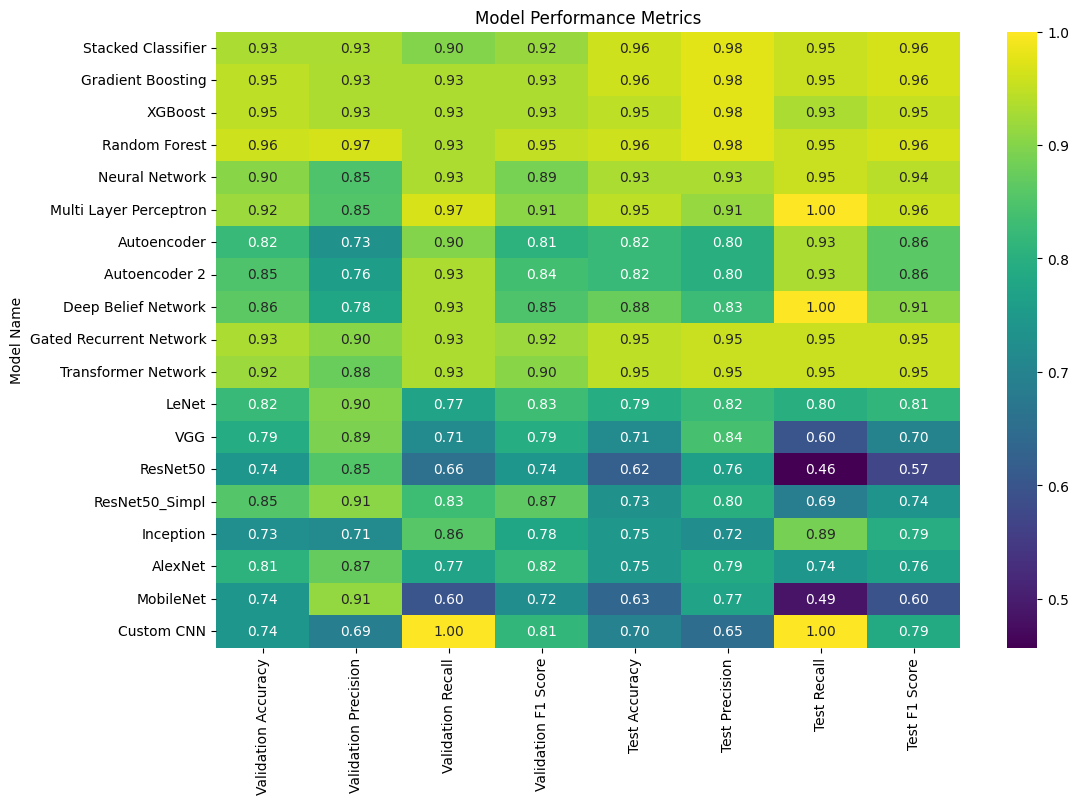

In [211]:
plt.figure(figsize=(12, 8))
sns.heatmap(model_metrics.set_index('Model Name').drop(['Test AUC', 'Validation AUC','Type','Epoch','Batch Size'], axis=1),
            annot=True, cmap='viridis', fmt=".2f")
plt.title('Model Performance Metrics')
plt.show()

# `Functional CNN Modeling`

In [212]:
# Split data into training and other sets first
X = np.vstack((x1, x2))
y = np.concatenate((y1, y2))

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the training set. Fit the scaler on X_train only
scaler = MinMaxScaler()
X_train_reshaped = X_train.reshape(-1, 19)  # Reshape to 2D array for scaling
scaler.fit(X_train_reshaped)  # Fit on the training data only

# Transform the training data
X_train_scaled = scaler.transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(X_train.shape)

# Transform the validation and test sets based on the scaler fitted on the training data
X_val_reshaped = X_val.reshape(-1, 19)
X_val_scaled = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled.reshape(X_val.shape)

X_test_reshaped = X_test.reshape(-1, 19)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Resize the images after scaling, if needed
X_train_resized = resize(X_train_scaled, (X_train_scaled.shape[0], 32, 32, 19))
X_val_resized = resize(X_val_scaled, (X_val_scaled.shape[0], 32, 32, 19))
X_test_resized = resize(X_test_scaled, (X_test_scaled.shape[0], 32, 32, 19))

# Your final variables for model training and evaluation
print(X_train_resized.shape, X_val_resized.shape, X_test_resized.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(290, 32, 32, 19) (62, 32, 32, 19) (63, 32, 32, 19)
(290,) (62,) (63,)


In [213]:
X_train = X_train_resized
X_val = X_val_resized
X_test = X_test_resized

# ResNet50 - Funcitonal Model 

In [214]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

In [215]:

# Load pre-trained ResNet50 model without the top layer
input_tensor = Input(shape=(32, 32, 19))
base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 32, 32, 19)]         0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 19)           0         ['input_16[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           59648     ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [216]:
# Train the model on your data
history=model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


2024-03-21 19:21:33.117093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


10/10 [==============================] - 9s 381ms/step - loss: 0.6897 - accuracy: 0.5103 - val_loss: 0.6748 - val_accuracy: 0.5645
Epoch 2/20
10/10 [==============================] - 0s 45ms/step - loss: 0.6871 - accuracy: 0.5241 - val_loss: 0.6707 - val_accuracy: 0.5645
Epoch 3/20
10/10 [==============================] - 0s 39ms/step - loss: 0.6797 - accuracy: 0.5310 - val_loss: 0.6662 - val_accuracy: 0.5645
Epoch 4/20
10/10 [==============================] - 0s 42ms/step - loss: 0.6837 - accuracy: 0.5276 - val_loss: 0.6704 - val_accuracy: 0.6452
Epoch 5/20
10/10 [==============================] - 0s 30ms/step - loss: 0.6805 - accuracy: 0.6172 - val_loss: 0.6681 - val_accuracy: 0.8226
Epoch 6/20
10/10 [==============================] - 0s 30ms/step - loss: 0.6824 - accuracy: 0.5724 - val_loss: 0.6569 - val_accuracy: 0.5645
Epoch 7/20
10/10 [==============================] - 0s 31ms/step - loss: 0.6765 - accuracy: 0.5276 - val_loss: 0.6534 - val_accuracy: 0.5645
Epoch 8/20
10/10 [=====

In [217]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)

# Predict on validation set
y_pred_proba_val = model.predict(X_val)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

# Predict on test set
y_pred_proba_test = model.predict(X_test)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)

# Evaluation on Validation Set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1score_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Validation Accuracy :", accuracy_val)
print("Validation Precision:", precision_val)
print("Validation Recall   :", recall_val)
print("Validation F1 Score :", f1score_val)
print("Validation AUC      :", auc_val)

# Evaluation on Test Set
accuracy_test=test_acc
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1score_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print('Test accuracy       :', accuracy_test)
print("Test Precision      :", precision_test)
print("Test Recall         :", recall_test)
print("Test F1 Score       :", f1score_test)
print("Test AUC            :", auc_test)

1/2 [==============>...............] - ETA: 0s - loss: 0.6159 - accuracy: 0.7188

2/2 [==============================] - 1s 855ms/step
Validation Accuracy : 0.6129032258064516
Validation Precision: 0.5932203389830508
Validation Recall   : 1.0
Validation F1 Score : 0.7446808510638298
Validation AUC      : 0.8677248677248677
Test accuracy       : 0.6349206566810608
Test Precision      : 0.603448275862069
Test Recall         : 1.0
Test F1 Score       : 0.7526881720430108
Test AUC            : 0.7530612244897958


***